# 3本同じ方向に動いたら逆張り

In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import datetime
from statistics import mean
from statistics import median
import calendar
import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb
import math

In [2]:
# OANDA API v20の口座IDとAPIトークン
accountID = "101-009-12609641-001"
access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"
# OANDAのデモ口座へのAPI接続
api = API(access_token=access_token, environment="practice")

## 関数定義

In [3]:
# APIから取得したレートをPandasのDataFrameへ
def to_dataframe(r):
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(float)
    return df

In [4]:
# 第何何曜日（第nX曜日）の日付を返す関数
def get_day_of_nth_dow(year, month, nth, dow):
    '''dow: Monday(0) - Sunday(6)'''
    if nth < 1 or dow < 0 or dow > 6:
        return None

    first_dow, n = calendar.monthrange(year, month)
    day = 7 * (nth - 1) + (dow - first_dow) % 7 + 1

    return day if day <= n else None

In [5]:
def get_data(count, gran, year, month, day, hour, minute, second):
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=hour, minute=minute, second=second).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from,
#         'dailyAlignment': 0
    }
    r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
    api.request(r)
    df = to_dataframe(r)
    return df

In [6]:
def get_data_super(start, end, gran):
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12789646-001"
    access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")
    # xxxx-xx-xx～xxxx-xx-xx の期間のデータを取得してデータフレームを返す
    s_year, s_month, s_day, s_hour, s_minute, s_second = map(int, start.split('-'))
    e_year, e_month, e_day, e_hour, e_minute, e_second = map(int, end.split('-'))
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    from_ = datetime.datetime(year=s_year, month=s_month, day=s_day,
                              hour=s_hour, minute=s_minute, second=s_second).strftime(fmt)
    to_ = datetime.datetime(year=e_year, month=e_month, day=e_day,
                            hour=e_hour, minute=e_minute, second=e_second).strftime(fmt)
    to_dt = '{}-{}-{} {}:{}:{}'.format(e_year, e_month, e_day, e_hour, e_minute, e_second)
    to_unix = datetime.datetime.strptime(to_dt, '%Y-%m-%d %H:%M:%S').timestamp()
    df = pd.DataFrame()
    # 5000個制限に引っかからなければこっちの処理
    try:
        params = {
            "granularity": gran,
            'from': from_,
            'to': to_
        }
        r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
        api.request(r)
        df = to_dataframe(r)
    # 引っかかればこっちの処理
    except:
        i = True
        while i:
            df_tmp = get_data(count=5000, gran=gran, year=s_year, month=s_month, day=s_day,
                             hour=s_hour, minute=s_minute, second=s_second)
            # ケツが同じなら止める (最新迄用)
            if df.tail(1).reset_index(drop=True).equals(df_tmp.tail(1).reset_index(drop=True)):
                i = False
            else:
                df = pd.concat([df, df_tmp[:-1]], ignore_index=True)
                index = df_tmp.tail(1).index[0]
                s_year = df_tmp.iat[index, 0].year
                s_month = df_tmp.iat[index, 0].month
                s_day = df_tmp.iat[index, 0].day
                s_hour = df_tmp.iat[index, 0].hour
                s_minute = df_tmp.iat[index, 0].minute
                s_second = df_tmp.iat[index, 0].second
                # 5000個ずつ取得してエンドの unix 超えたら止める
                if to_unix < df.iat[df.tail(1).index[0], 0].timestamp():
                    # はみ出した分をここで切り落とす
                    for i in range(len(df.index) - 5000, len(df.index)):
                        if to_unix <= df.iat[i, 0].timestamp():
                            df = df[:i]
                            break
                    i = False
    return df

In [90]:
def get_evaluation(pos_df, return_=False):
    # 勝率
    win_c = pos_df[pos_df['pips'] >=0].shape[0]
    P = win_c / len(pos_df.index)
    # ペイオフレシオ
    win_p = mean(pos_df[pos_df['pips'] >=0]['pips'])
    los_p = mean(pos_df[pos_df['pips'] < 0]['pips']) * (-1)
    R = win_p / los_p
    # プロフィットファクター
    pf = pos_df[pos_df['profit']>0]['profit'].sum() / pos_df[pos_df['profit']<=0]['profit'].sum() * (-1)
    # 期待値
    win_pro = mean(pos_df[pos_df['pips'] >=0]['profit'])
    los_pro = mean(pos_df[pos_df['pips'] < 0]['profit']) * (-1)
    E = P * win_pro - pos_df[pos_df['pips'] < 0].shape[0] / len(pos_df.index) * los_pro
    # 最大ドローダウン
    dd = pos_df.sort_values(by='pips', ascending=True).head(1)['pips'].values[0]
    # ケリー基準
    kly = ((R + 1) * P - 1) / R
    if return_:
        # WP, POR, PF, E, DD, KLY
        return round(P*100, 2), round(R, 4), round(pf, 4), round(E, 3), round(dd, 1), round(kly*100, 2)
    else:
        print('勝率: {:.2f}%'.format(P*100))
        print('ペイオフレシオ: {:.4f}'.format(R))
        print('プロフィットファクター: {:.4f}'.format(pf))
        print('期待値: {:.3f}円'.format(E))
        print('最大ドローダウン: {:.1f}pips'.format(dd))
        print('ケリー基準: {:.2f}%'.format(kly*100))

In [8]:
def entry_plot(pos_df, df, type_='head', n=50, m=20, b=3):
    if type_ == 'head':
        indexes = pos_df.head(n).index
    elif type_ == 'lose_head':
        indexes = pos_df[pos_df['pips']<0].head(n).index
    elif type_ == 'win_head':
        indexes = pos_df[pos_df['pips']>=0].head(n).index
    elif type_ == 'sort_t':
        indexes = pos_df.sort_values(by='pips', ascending=True).head(n).index
    elif type_ == 'sort_f':
        indexes = pos_df.sort_values(by='pips', ascending=False).head(n).index
    for idx in indexes:
        entry_date = pos_df[idx:idx+1]['entry_date'].values[0]
        l_or_s = pos_df[idx:idx+1]['l_or_s'].values[0]
        i = df[df['Time']==entry_date].index[0]
        plt.title(entry_date)
        plt.plot(df[i-b:i+m]['Open'], 'C1o', label="Open")
        plt.plot(df[i-b:i+m]['Close'], 'C0o', label="Close")
        plt.vlines(i, df[i-b:i+m]['Close'].max(), df[i-b:i+m]['Close'].min(),
                  "green" if l_or_s =='long' else 'red', linestyles='dashed', label=l_or_s)
        plt.legend()
        plt.show()

## 読み込み

In [9]:
dfm5 = pd.read_csv('dfm5.csv')
dfm1 = pd.read_csv('dfm1.csv')

## 検証

### BT1

In [12]:
# バックテスト
def back_test(m, seed_money, df='None', start='', end='', gran='M5', lot=10, kly_rate='None'):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    tmp_i = 0
    assets = seed_money
    lot = 10
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    pos_df = pd.DataFrame(columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])

    # 実行
    for i in range(3, len(df.index) - (1+m)):
        # up or down (Open - Close)
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud1 > 0 and ud2 > 0 and ud3 > 0:
            if pos == 'None':
                entry_rate = df.iat[i, 2] # 始値(entry)
                exit_rate = df.iat[i+m, 5] # m本後の終値
                pips = (exit_rate - entry_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'long', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                pos = 'entry_long'
                tmp_i = i
        # 下降トレンドと判断しショート
        if ud1 < 0 and ud2 < 0 and ud3 < 0:
            if pos == 'None':
                entry_rate = df.iat[i, 2] # 始値(entry)
                exit_rate = df.iat[i+m, 5] # m本後の終値
                pips = (entry_rate - exit_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'short', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                pos = 'entry_short'
                tmp_i = i
        
    print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    if isinstance(df, pd.DataFrame):
        return pos_df
    else:
        return pos_df, df

In [118]:
# バックテスト(高速化)
def back_test_fast(m, seed_money, df='None', start='', end='', gran='M5', ref=3, lot=10, kly_rate='None', print_=True):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    tmp_i = 0
    assets = seed_money
    lot = 10
    lot_l = []
    l_or_s = []
    entry_date = []
    entry_rate_l = []
    exit_date = []
    exit_rate_l = []
    pips_l = []
    profit_l = []
    assets_l = []
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    # 実行
    for i in range(3, len(df.index) - (1+m)):
        # up or down (Open - Close)
        uds1 = []
        uds2 = []
        for j in range(1, ref+1):
            uds1.extend([df.iat[i-j, 2] - df.iat[i-j, 5] > 0])
            uds2.extend([df.iat[i-j, 2] - df.iat[i-j, 5] < 0])
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # ロング
        if all(uds1):
            if pos == 'None':
                entry_rate = df.iat[i, 2] # 始値(entry)
                exit_rate = df.iat[i+m, 5] # m本後の終値
                pips = (exit_rate - entry_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                lot_l.extend([lot])
                l_or_s.extend(['long'])
                entry_date.extend([df.iat[i, 0]])
                entry_rate_l.extend([entry_rate])
                exit_date.extend([df.iat[i+m, 0]])
                exit_rate_l.extend([exit_rate])
                pips_l.extend([pips])
                profit_l.extend([profit])
                assets_l.extend([assets])
                if assets < 0:
                    break
                pos = 'entry_long'
                tmp_i = i
        # ショート
        if all(uds2):
            if pos == 'None':
                entry_rate = df.iat[i, 2] # 始値(entry)
                exit_rate = df.iat[i+m, 5] # m本後の終値
                pips = (entry_rate - exit_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                lot_l.extend([lot])
                l_or_s.extend(['short'])
                entry_date.extend([df.iat[i, 0]])
                entry_rate_l.extend([entry_rate])
                exit_date.extend([df.iat[i+m, 0]])
                exit_rate_l.extend([exit_rate])
                pips_l.extend([pips])
                profit_l.extend([profit])
                assets_l.extend([assets])
                if assets < 0:
                    break
                pos = 'entry_short'
                tmp_i = i
    
    pos_df = pd.DataFrame(data={'lot': lot_l, 'l_or_s': l_or_s, 'entry_date': entry_date, 'entry_rate': entry_rate_l,
                                'exit_date': exit_date, 'exit_rate': exit_rate_l, 'pips': pips_l, 'profit': profit_l,
                                'assets':assets_l},
                          columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    if print_:
        print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    if isinstance(df, pd.DataFrame):
        return pos_df
    else:
        return pos_df, df

In [82]:
# バックテスト簡易版
def back_test_easy(df, m, start='', end='', gran='M5', ref=3):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    profit_list = []
    pos_count = 0
    tmp_i = 0
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    # 実行
    for i in range(3, len(df.index) - (1+m)):
        entry_rate = df.iat[i, 2] # 始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値(exit)
        # up or down (Open - Close)
        uds1 = []
        uds2 = []
        for j in range(1, ref+1):
            uds1.extend([df.iat[i-j, 2] - df.iat[i-j, 5] > 0])
            uds2.extend([df.iat[i-j, 2] - df.iat[i-j, 5] < 0])
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # ロング
        if all(uds1):
            if pos == 'None':
                profit = exit_rate - entry_rate - fee
                profit_list.append(profit)
                pos = 'entry_long'
                pos_count+=1
                tmp_i = i
        # ショート
        if all(uds2):
            if pos == 'None':
                profit = entry_rate - exit_rate - fee
                profit_list.append(profit)
                pos = 'entry_short'
                pos_count+=1
                tmp_i = i
        
    print('pos count: {:>8}, profit: {:>10.3f}'.format(pos_count, sum(profit_list)))
    return pos_count, round(sum(profit_list), 3)

#### M5

In [133]:
dfm5 = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', 'M5')

In [95]:
refmdf = pd.DataFrame(columns=['ref', 'm', 'pos_count', 'profit', 'WP(%)', 'POR', 'PF', 'E(円)', 'DD(pips)', 'KLY(%)'])
for r in range(2, 10+1):
    for m in range(1, 50+1):
        print('ref: {:>2}, m: {:>2}, '.format(r, m), end='')
        pos_df = back_test_fast(m=m, df=dfm5, seed_money=1000000, ref=r, print_=False)
        pos_count, profit = pos_df.shape[0], pos_df['pips'].sum() / 100
        WP, POR, PF, E, DD, KLY = get_evaluation(pos_df, return_=True)
        print('pos count: {:>8}, profit: {:>10.3f}'.format(pos_count, profit))
        tmp_se = pd.Series([r, m, pos_count, profit, WP, POR, PF, E, DD, KLY], index=refmdf.columns)
        refmdf = refmdf.append(tmp_se, ignore_index=True)

ref:  2, m:  1, pos count:   301559, profit:   -200.259
ref:  2, m:  2, pos count:   207201, profit:   -161.475
ref:  2, m:  3, pos count:   158446, profit:    -79.790
ref:  2, m:  4, pos count:   128203, profit:    -95.097
ref:  2, m:  5, pos count:   107778, profit:    -97.614
ref:  2, m:  6, pos count:    92879, profit:    -62.217
ref:  2, m:  7, pos count:    81634, profit:    -18.745
ref:  2, m:  8, pos count:    72796, profit:    -61.227
ref:  2, m:  9, pos count:    65773, profit:    -34.794
ref:  2, m: 10, pos count:    59900, profit:    -49.944
ref:  2, m: 11, pos count:    55014, profit:     17.033
ref:  2, m: 12, pos count:    50845, profit:    -16.737
ref:  2, m: 13, pos count:    47317, profit:    -16.886
ref:  2, m: 14, pos count:    44189, profit:     -8.077
ref:  2, m: 15, pos count:    41485, profit:      5.254
ref:  2, m: 16, pos count:    39074, profit:    -52.112
ref:  2, m: 17, pos count:    36941, profit:    -38.683
ref:  2, m: 18, pos count:    35006, profit:    

ref:  4, m: 48, pos count:    10688, profit:      9.992
ref:  4, m: 49, pos count:    10508, profit:     12.737
ref:  4, m: 50, pos count:    10338, profit:     -3.030
ref:  5, m:  1, pos count:    26117, profit:     40.604
ref:  5, m:  2, pos count:    18269, profit:     19.789
ref:  5, m:  3, pos count:    16260, profit:     12.538
ref:  5, m:  4, pos count:    15517, profit:     10.231
ref:  5, m:  5, pos count:    15265, profit:     18.682
ref:  5, m:  6, pos count:    14915, profit:     20.623
ref:  5, m:  7, pos count:    14596, profit:      9.745
ref:  5, m:  8, pos count:    14302, profit:     13.579
ref:  5, m:  9, pos count:    14035, profit:      8.280
ref:  5, m: 10, pos count:    13718, profit:      0.688
ref:  5, m: 11, pos count:    13433, profit:      5.258
ref:  5, m: 12, pos count:    13188, profit:     16.581
ref:  5, m: 13, pos count:    12942, profit:     13.194
ref:  5, m: 14, pos count:    12696, profit:     14.037
ref:  5, m: 15, pos count:    12475, profit:    

ref:  7, m: 45, pos count:     2309, profit:      5.404
ref:  7, m: 46, pos count:     2303, profit:      7.450
ref:  7, m: 47, pos count:     2299, profit:      4.723
ref:  7, m: 48, pos count:     2292, profit:      7.571
ref:  7, m: 49, pos count:     2285, profit:      9.170
ref:  7, m: 50, pos count:     2272, profit:      8.053
ref:  8, m:  1, pos count:     1960, profit:     -0.566
ref:  8, m:  2, pos count:     1396, profit:     -1.656
ref:  8, m:  3, pos count:     1223, profit:     -0.678
ref:  8, m:  4, pos count:     1165, profit:     -2.859
ref:  8, m:  5, pos count:     1148, profit:     -1.095
ref:  8, m:  6, pos count:     1140, profit:     -0.942
ref:  8, m:  7, pos count:     1137, profit:     -0.700
ref:  8, m:  8, pos count:     1136, profit:     -1.761
ref:  8, m:  9, pos count:     1133, profit:      0.095
ref:  8, m: 10, pos count:     1130, profit:     -0.561
ref:  8, m: 11, pos count:     1128, profit:     -1.231
ref:  8, m: 12, pos count:     1124, profit:    

ref: 10, m: 42, pos count:      223, profit:     -0.322
ref: 10, m: 43, pos count:      223, profit:     -0.506
ref: 10, m: 44, pos count:      223, profit:     -0.500
ref: 10, m: 45, pos count:      223, profit:      0.295
ref: 10, m: 46, pos count:      223, profit:     -0.097
ref: 10, m: 47, pos count:      223, profit:     -1.353
ref: 10, m: 48, pos count:      223, profit:     -2.245
ref: 10, m: 49, pos count:      223, profit:     -2.431
ref: 10, m: 50, pos count:      223, profit:     -2.558


In [97]:
refmdf.sort_values(by='profit', ascending=False)

ref     m  pos_count   profit  WP(%)     POR      PF   E(円)  DD(pips)  \
24   2.0  25.0    25671.0   73.726  51.17  1.0033  1.0513  0.029    -327.6   
83   3.0  34.0    17228.0   69.679  50.92  1.0231  1.0614  0.040    -345.2   
81   3.0  32.0    18131.0   54.417  50.91  1.0095  1.0468  0.030    -345.0   
44   2.0  45.0    14581.0   53.355  50.61  1.0232  1.0483  0.037    -295.6   
37   2.0  38.0    17177.0   50.186  50.48  1.0220  1.0418  0.029    -335.8   
70   3.0  21.0    25788.0   48.174  51.30  0.9830  1.0354  0.019    -345.8   
58   3.0   9.0    47781.0   44.976  51.92  0.9505  1.0263  0.009    -441.6   
82   3.0  33.0    17652.0   44.300  50.83  1.0044  1.0384  0.025    -345.2   
60   3.0  11.0    41781.0   41.701  51.55  0.9635  1.0254  0.010    -344.6   
59   3.0  10.0    44602.0   41.435  51.63  0.9601  1.0248  0.009    -300.9   
84   3.0  35.0    16787.0   40.748  50.83  1.0022  1.0359  0.024    -345.2   
150  5.0   1.0    26117.0   40.604  54.47  0.9106  1.0894  0.016    -258.8   
30   2.0  31.0    20905.0   37.232  50.55  1.0058  1.0281  0.018    -321.7   
106  4.0   7.0    30533.0   35.808  52.27  0.9464  1.0363  0.012    -191.1   
100  4.0   1.0    60210.0   35.000  53.08  0.9140  1.0338  0.006    -258.8   
69   3.0  20.0    26785.0   34.135  51.42  0.9678  1.0245  0.013    -351.8   
249  6.0  50.0     4539.0   33.556  51.66  1.0203  1.0905  0.074    -190.6   
64   3.0  15.0    33400.0   32.883  51.27  0.9713  1.0219  0.010    -279.8   
22   2.0  23.0    27806.0   32.016  50.71  0.9924  1.0211  0.012    -334.7   
68   3.0  19.0    27929.0   29.878  51.14  0.9755  1.0210  0.011    -380.8   
78   3.0  29.0    19776.0   29.777  50.88  0.9889  1.0243  0.015    -345.4   
63   3.0  14.0    35207.0   29.234  51.19  0.9715  1.0190  0.008    -272.4   
141  4.0  42.0    11797.0   28.344  51.23  0.9826  1.0323  0.024    -242.9   
107  4.0   8.0    29230.0   28.266  52.37  0.9349  1.0279  0.010    -434.2   
57   3.0   8.0    51385.0   28.073  51.65  0.9512  1.0161  0.005    -271.2   
39   2.0  40.0    16360.0   27.925  50.65  0.9971  1.0235  0.017    -354.4   
43   2.0  44.0    14909.0   27.647  50.49  1.0048  1.0246  0.019    -370.5   
248  6.0  49.0     4578.0   27.334  51.42  1.0140  1.0732  0.060    -186.8   
96   3.0  47.0    12934.0   27.196  51.02  0.9857  1.0268  0.021    -345.5   
89   3.0  40.0    14922.0   27.063  51.33  0.9717  1.0247  0.018    -332.2   
..   ...   ...        ...      ...    ...     ...     ...    ...       ...   
111  4.0  12.0    24832.0  -14.190  51.28  0.9370  0.9864 -0.006    -318.5   
174  5.0  25.0    10502.0  -14.426  51.44  0.9226  0.9772 -0.014    -362.8   
175  5.0  26.0    10349.0  -14.856  51.27  0.9283  0.9767 -0.014    -353.4   
88   3.0  39.0    15274.0  -15.695  51.02  0.9465  0.9859 -0.010    -484.6   
134  4.0  35.0    13446.0  -15.703  50.97  0.9459  0.9832 -0.012    -341.1   
114  4.0  15.0    22417.0  -15.994  51.36  0.9323  0.9846 -0.007    -277.0   
11   2.0  12.0    50845.0  -16.737  50.65  0.9663  0.9919 -0.003    -256.0   
12   2.0  13.0    47317.0  -16.886  50.24  0.9822  0.9915 -0.004    -320.8   
50   3.0   1.0   136298.0  -17.005  51.69  0.9278  0.9926 -0.001    -258.8   
33   2.0  34.0    19129.0  -18.530  50.00  0.9855  0.9856 -0.010    -279.1   
6    2.0   7.0    81634.0  -18.745  50.65  0.9673  0.9928 -0.002    -253.8   
27   2.0  28.0    23066.0  -20.145  50.08  0.9827  0.9857 -0.009    -303.0   
28   2.0  29.0    22301.0  -27.517  49.97  0.9814  0.9802 -0.012    -276.0   
42   2.0  43.0    15245.0  -29.764  49.97  0.9758  0.9746 -0.020    -337.8   
35   2.0  36.0    18106.0  -30.543  50.11  0.9716  0.9759 -0.017    -346.8   
25   2.0  26.0    24742.0  -31.254  50.27  0.9683  0.9788 -0.013    -239.6   
18   2.0  19.0    33293.0  -33.428  50.24  0.9710  0.9802 -0.010    -330.8   
8    2.0   9.0    65773.0  -34.794  50.66  0.9596  0.9851 -0.005    -274.8   
99   3.0  50.0    12210.0  -36.860  50.07  0.9618  0.9644 -0.030    -345.3   
16   2.0  17.0    36941.0  

In [101]:
refmdf.sort_values(by='KLY(%)', ascending=False)

ref     m  pos_count  profit  WP(%)     POR      PF   E(円)  DD(pips)  \
400  10.0   1.0      356.0   1.859  58.43  0.9220  1.2958  0.052     -29.7   
404  10.0   5.0      228.0   0.905  60.96  0.7159  1.1181  0.040    -198.0   
200   6.0   1.0    11080.0  22.334  55.53  0.8905  1.1121  0.020    -214.9   
201   6.0   2.0     7848.0  15.092  56.13  0.8505  1.0881  0.019    -320.4   
150   5.0   1.0    26117.0  40.604  54.47  0.9106  1.0894  0.016    -258.8   
249   6.0  50.0     4539.0  33.556  51.66  1.0203  1.0905  0.074    -190.6   
403  10.0   4.0      231.0   0.471  63.20  0.6196  1.0642  0.020    -223.4   
246   6.0  47.0     4631.0  27.060  51.76  1.0001  1.0731  0.058    -229.0   
248   6.0  49.0     4578.0  27.334  51.42  1.0140  1.0732  0.060    -186.8   
244   6.0  45.0     4694.0  26.742  51.60  1.0063  1.0728  0.057    -191.2   
239   6.0  40.0     4858.0  25.698  51.93  0.9916  1.0714  0.053    -243.6   
243   6.0  44.0     4723.0  25.903  51.64  1.0029  1.0709  0.055    -190.8   
204   6.0   5.0     6535.0  12.725  54.86  0.8774  1.0662  0.019    -239.6   
230   6.0  31.0     5203.0  24.152  51.53  1.0070  1.0705  0.046    -271.8   
237   6.0  38.0     4927.0  24.927  51.82  0.9948  1.0698  0.051    -269.4   
247   6.0  48.0     4609.0  25.960  51.46  1.0089  1.0698  0.056    -190.2   
229   6.0  30.0     5249.0  23.062  51.69  0.9978  1.0674  0.044    -280.8   
203   6.0   4.0     6683.0  11.371  55.07  0.8669  1.0623  0.017    -225.4   
245   6.0  46.0     4664.0  23.972  51.74  0.9931  1.0645  0.051    -220.3   
265   7.0  16.0     2579.0   8.004  52.97  0.9432  1.0621  0.031    -247.7   
242   6.0  43.0     4753.0  22.974  51.44  1.0035  1.0631  0.048    -220.1   
228   6.0  29.0     5299.0  21.288  51.65  0.9944  1.0624  0.040    -277.8   
231   6.0  32.0     5160.0  21.315  51.98  0.9808  1.0615  0.041    -279.8   
238   6.0  39.0     4892.0  22.101  52.04  0.9780  1.0613  0.045    -269.1   
83    3.0  34.0    17228.0  69.679  50.92  1.0231  1.0614  0.040    -345.2   
216   6.0  17.0     5887.0  17.349  52.81  0.9461  1.0588  0.029    -254.9   
277   7.0  28.0     2455.0   9.269  52.42  0.9606  1.0585  0.038    -270.6   
232   6.0  33.0     5114.0  20.393  51.97  0.9780  1.0585  0.040    -296.3   
213   6.0  14.0     6032.0  15.565  53.55  0.9160  1.0560  0.026    -289.3   
211   6.0  12.0     6151.0  14.551  53.78  0.9069  1.0553  0.024    -227.6   
..    ...   ...        ...     ...    ...     ...     ...    ...       ...   
422  10.0  23.0      227.0  -2.101  48.90  0.9019  0.8630 -0.093    -264.6   
355   9.0   6.0      469.0  -2.363  52.67  0.7813  0.8692 -0.050    -207.8   
359   9.0  10.0      467.0  -2.885  52.46  0.7860  0.8675 -0.062    -189.0   
401  10.0   2.0      260.0  -0.999  61.54  0.5501  0.8802 -0.038    -320.4   
364   9.0  15.0      465.0  -3.913  52.26  0.7764  0.8498 -0.084    -263.1   
362   9.0  13.0      465.0  -3.798  50.97  0.8132  0.8453 -0.082    -214.6   
354   9.0   5.0      472.0  -2.497  55.08  0.6971  0.8549 -0.053    -233.2   
366   9.0  17.0      464.0  -4.328  50.43  0.8289  0.8433 -0.093    -370.0   
353   9.0   4.0      480.0  -2.469  52.71  0.7566  0.8433 -0.051    -189.5   
358   9.0   9.0      468.0  -3.469  50.85  0.8095  0.8376 -0.074    -168.4   
357   9.0   8.0      468.0  -3.370  51.07  0.8017  0.8367 -0.072    -189.5   
360   9.0  11.0      466.0  -3.799  50.64  0.8128  0.8340 -0.082    -230.1   
421  10.0  22.0      227.0  -2.549  51.98  0.7706  0.8342 -0.112    -265.8   
420  10.0  21.0      227.0  -2.699  50.22  0.8123  0.8195 -0.119    -240.0   
365   9.0  16.0      465.0  -4.930  51.40  0.7765  0.8212 -0.106    -321.6   
408  10.0   9.0      227.0  -1.940  53.30  0.7158  0.8171 -0.085    -179.2   
417  10.0  18.0      227.0  -2.627  53.74  0.7008  0.8143 -0.116    -262.0   
361   9.0  12.0      465.0  -4.836  49.89  0.8019  0.7984 -0.104    -217.8   
412  10.0  13.0      227.0  -2.456  51.98  0.7430  0.8043 -0.108    -185.9   
416  10.0  17.0      227.0  

In [117]:
refmdf.sort_values(by='PF', ascending=False)

ref     m  pos_count  profit  WP(%)     POR      PF   E(円)  DD(pips)  \
400  10.0   1.0      356.0   1.859  58.43  0.9220  1.2958  0.052     -29.7   
404  10.0   5.0      228.0   0.905  60.96  0.7159  1.1181  0.040    -198.0   
200   6.0   1.0    11080.0  22.334  55.53  0.8905  1.1121  0.020    -214.9   
249   6.0  50.0     4539.0  33.556  51.66  1.0203  1.0905  0.074    -190.6   
150   5.0   1.0    26117.0  40.604  54.47  0.9106  1.0894  0.016    -258.8   
201   6.0   2.0     7848.0  15.092  56.13  0.8505  1.0881  0.019    -320.4   
248   6.0  49.0     4578.0  27.334  51.42  1.0140  1.0732  0.060    -186.8   
246   6.0  47.0     4631.0  27.060  51.76  1.0001  1.0731  0.058    -229.0   
244   6.0  45.0     4694.0  26.742  51.60  1.0063  1.0728  0.057    -191.2   
239   6.0  40.0     4858.0  25.698  51.93  0.9916  1.0714  0.053    -243.6   
243   6.0  44.0     4723.0  25.903  51.64  1.0029  1.0709  0.055    -190.8   
230   6.0  31.0     5203.0  24.152  51.53  1.0070  1.0705  0.046    -271.8   
247   6.0  48.0     4609.0  25.960  51.46  1.0089  1.0698  0.056    -190.2   
237   6.0  38.0     4927.0  24.927  51.82  0.9948  1.0698  0.051    -269.4   
229   6.0  30.0     5249.0  23.062  51.69  0.9978  1.0674  0.044    -280.8   
204   6.0   5.0     6535.0  12.725  54.86  0.8774  1.0662  0.019    -239.6   
245   6.0  46.0     4664.0  23.972  51.74  0.9931  1.0645  0.051    -220.3   
403  10.0   4.0      231.0   0.471  63.20  0.6196  1.0642  0.020    -223.4   
242   6.0  43.0     4753.0  22.974  51.44  1.0035  1.0631  0.048    -220.1   
228   6.0  29.0     5299.0  21.288  51.65  0.9944  1.0624  0.040    -277.8   
203   6.0   4.0     6683.0  11.371  55.07  0.8669  1.0623  0.017    -225.4   
265   7.0  16.0     2579.0   8.004  52.97  0.9432  1.0621  0.031    -247.7   
231   6.0  32.0     5160.0  21.315  51.98  0.9808  1.0615  0.041    -279.8   
83    3.0  34.0    17228.0  69.679  50.92  1.0231  1.0614  0.040    -345.2   
238   6.0  39.0     4892.0  22.101  52.04  0.9780  1.0613  0.045    -269.1   
396   9.0  47.0      451.0   2.331  48.34  1.1340  1.0610  0.052    -120.4   
216   6.0  17.0     5887.0  17.349  52.81  0.9461  1.0588  0.029    -254.9   
277   7.0  28.0     2455.0   9.269  52.42  0.9606  1.0585  0.038    -270.6   
232   6.0  33.0     5114.0  20.393  51.97  0.9780  1.0585  0.040    -296.3   
241   6.0  42.0     4784.0  20.842  51.55  0.9935  1.0569  0.044    -214.8   
..    ...   ...        ...     ...    ...     ...     ...    ...       ...   
367   9.0  18.0      464.0  -3.636  49.35  0.8912  0.8685 -0.078    -282.8   
359   9.0  10.0      467.0  -2.885  52.46  0.7860  0.8675 -0.062    -189.0   
369   9.0  20.0      463.0  -3.892  48.81  0.9075  0.8653 -0.084    -254.2   
422  10.0  23.0      227.0  -2.101  48.90  0.9019  0.8630 -0.093    -264.6   
354   9.0   5.0      472.0  -2.497  55.08  0.6971  0.8549 -0.053    -233.2   
364   9.0  15.0      465.0  -3.913  52.26  0.7764  0.8498 -0.084    -263.1   
362   9.0  13.0      465.0  -3.798  50.97  0.8132  0.8453 -0.082    -214.6   
353   9.0   4.0      480.0  -2.469  52.71  0.7566  0.8433 -0.051    -189.5   
366   9.0  17.0      464.0  -4.328  50.43  0.8289  0.8433 -0.093    -370.0   
358   9.0   9.0      468.0  -3.469  50.85  0.8095  0.8376 -0.074    -168.4   
357   9.0   8.0      468.0  -3.370  51.07  0.8017  0.8367 -0.072    -189.5   
421  10.0  22.0      227.0  -2.549  51.98  0.7706  0.8342 -0.112    -265.8   
360   9.0  11.0      466.0  -3.799  50.64  0.8128  0.8340 -0.082    -230.1   
365   9.0  16.0      465.0  -4.930  51.40  0.7765  0.8212 -0.106    -321.6   
420  10.0  21.0      227.0  -2.699  50.22  0.8123  0.8195 -0.119    -240.0   
408  10.0   9.0      227.0  -1.940  53.30  0.7158  0.8171 -0.085    -179.2   
417  10.0  18.0      227.0  -2.627  53.74  0.7008  0.8143 -0.116    -262.0   
412  10.0  13.0      227.0  -2.456  51.98  0.7430  0.8043 -0.108    -185.9   
416  10.0  17.0      227.0  -2.815  53.30  0.7028  0.8022 -0.124    -273.0   
361   9.0  12.0      465.0  

In [144]:
pos_df = back_test_fast(df=dfm5, ref=5, m=1, seed_money=1000000)

pos count: 29068, assets: 1449710円


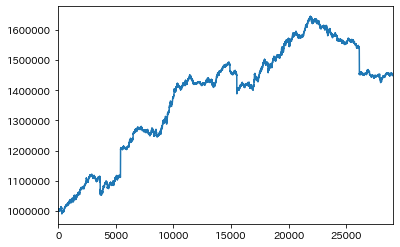

In [145]:
pos_df['assets'].plot()

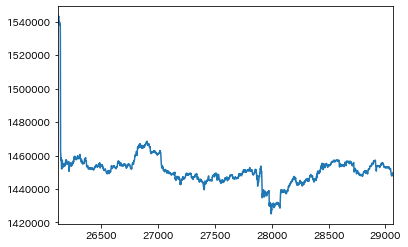

In [146]:
pos_df[pos_df['entry_date'].dt.year==2019]['assets'].plot()

In [113]:
get_evaluation(pos_df)

勝率: 58.43%
ペイオフレシオ: 0.9220
プロフィットファクター: 1.2958
期待値: 0.052円
最大ドローダウン: -29.7pips
ケリー基準: 13.34%


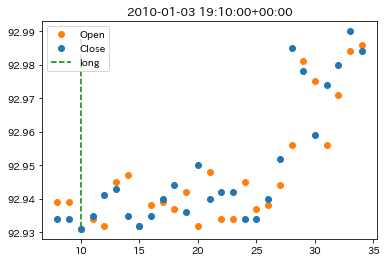

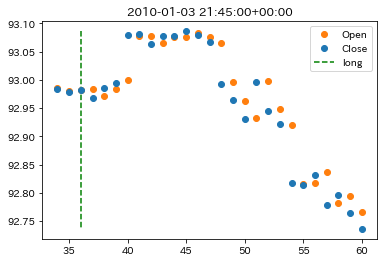

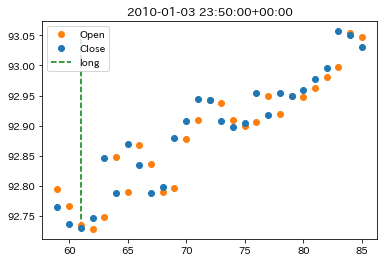

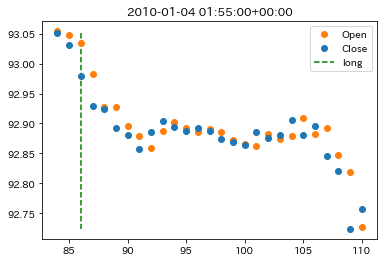

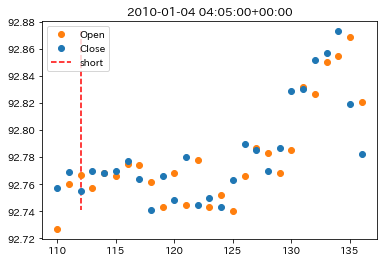

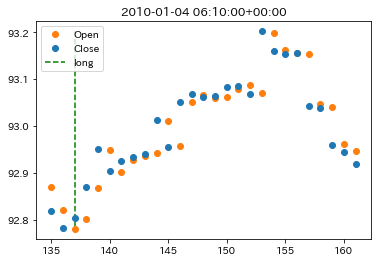

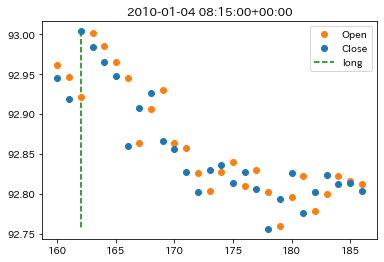

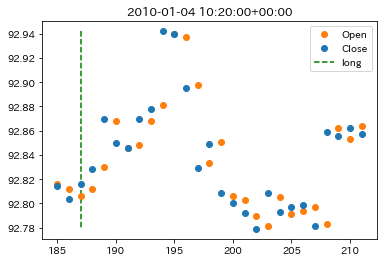

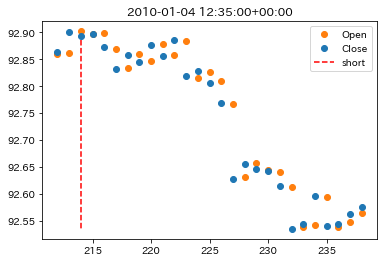

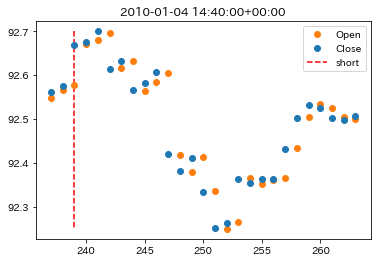

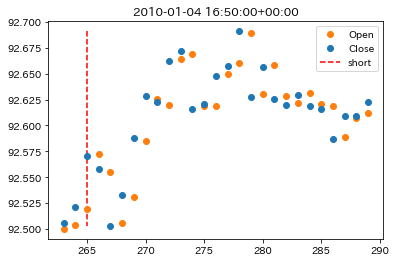

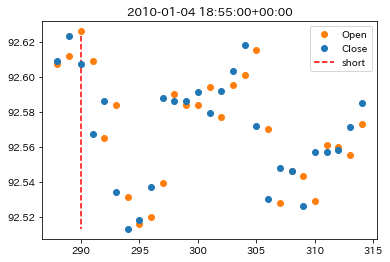

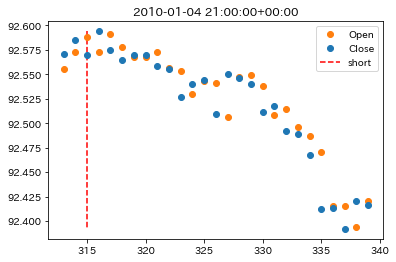

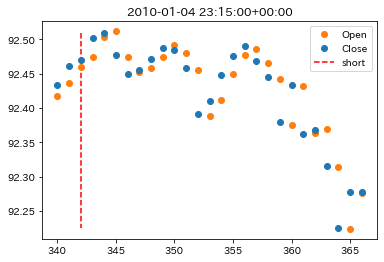

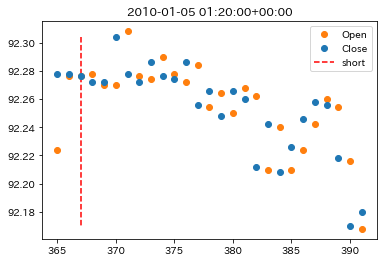

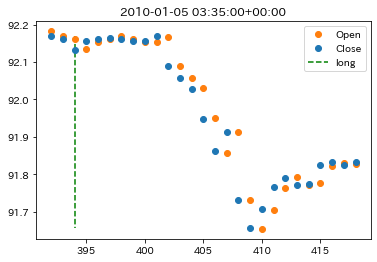

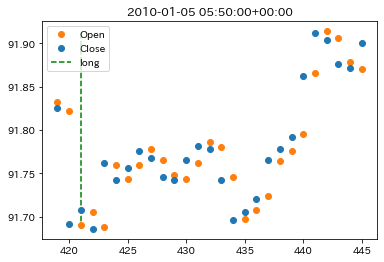

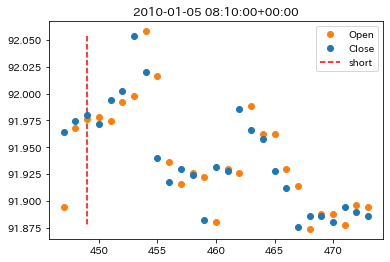

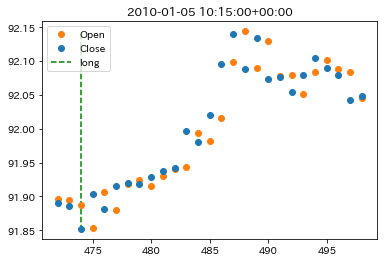

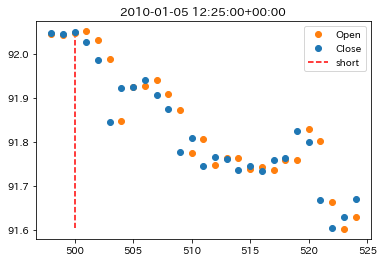

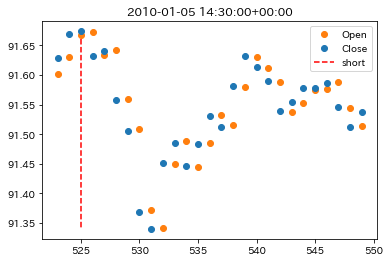

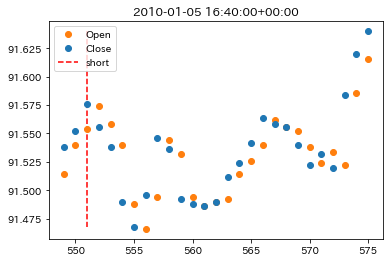

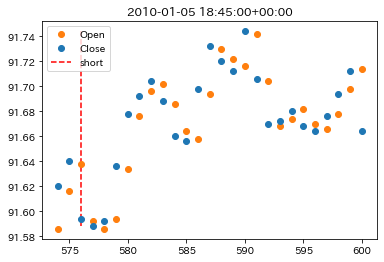

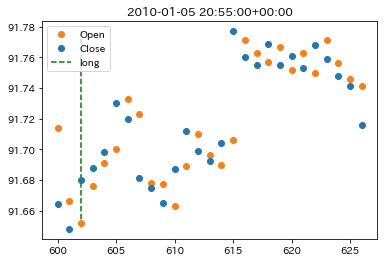

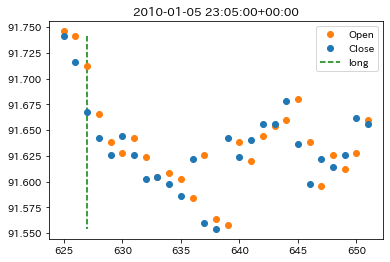

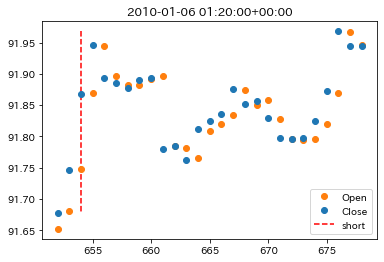

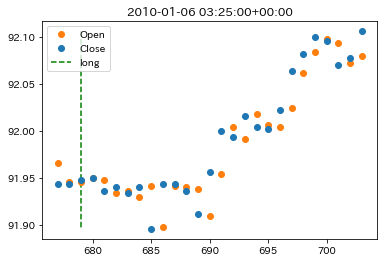

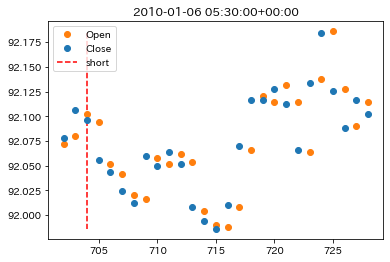

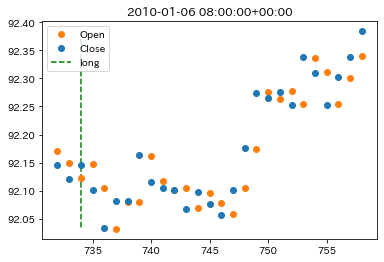

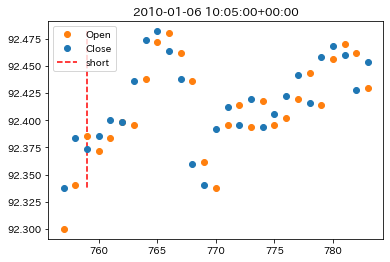

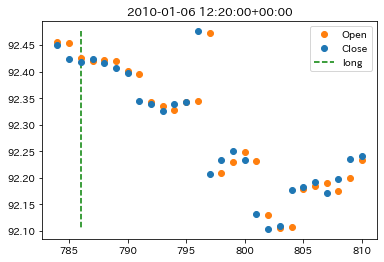

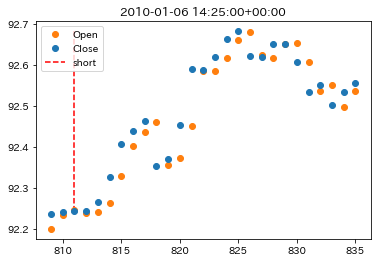

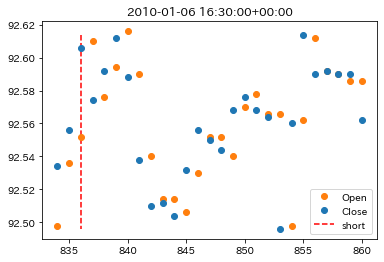

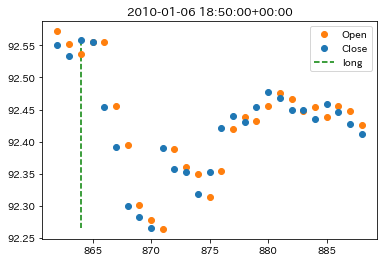

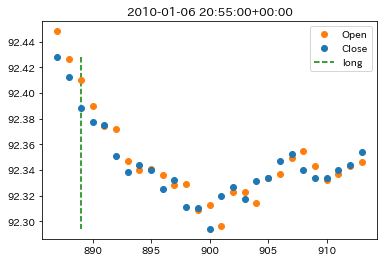

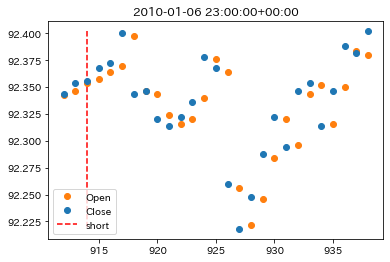

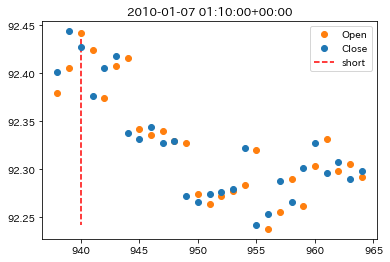

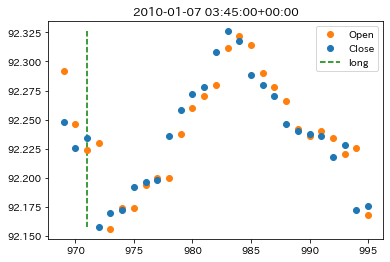

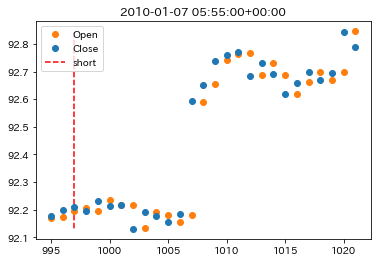

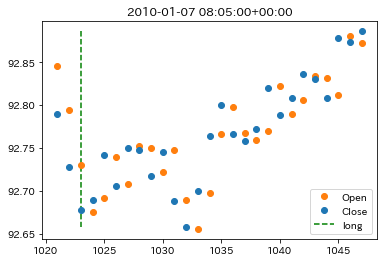

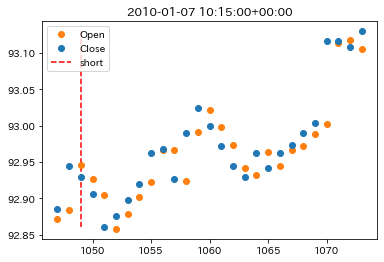

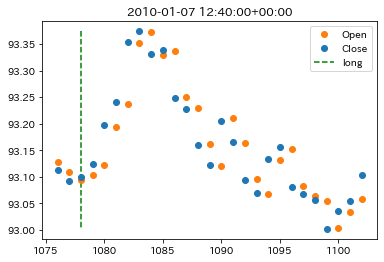

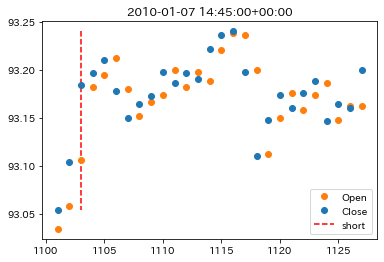

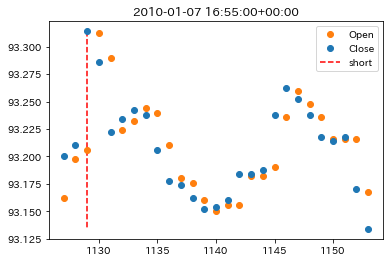

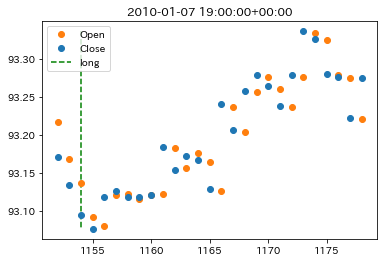

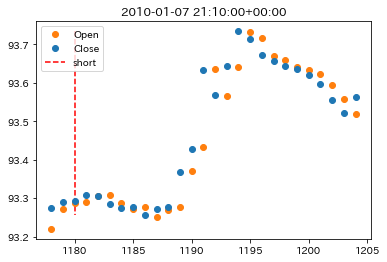

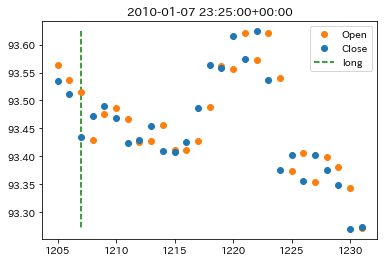

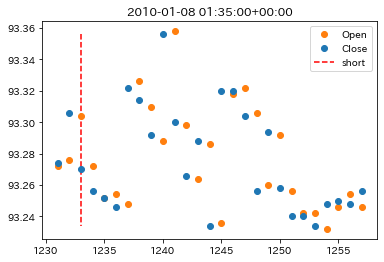

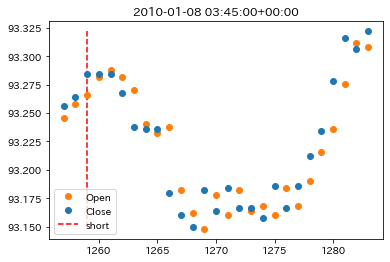

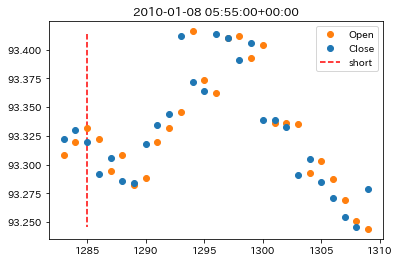

In [132]:
entry_plot(df=dfm5, pos_df=pos_df, type_='head', b=2, m=25)

#### M1

In [18]:
dfm1 = get_data_super('2010-01-01-00-00-00', '2019-01-01-00-00-00', 'M1')

In [20]:
for i in range(1, 50):
    print('m: {}, '.format(i), end='')
    back_test_easy(dfm1[dfm1['Time'].dt.year==2018], m=i)

m: 1, pos count: 63895, profit: -101.527
m: 2, pos count: 44242, profit: -61.076
m: 3, pos count: 38848, profit: -54.322
m: 4, pos count: 34819, profit: -45.992
m: 5, pos count: 31631, profit: -39.757
m: 6, pos count: 28947, profit: -35.421
m: 7, pos count: 26767, profit: -36.515
m: 8, pos count: 24916, profit: -33.971
m: 9, pos count: 23324, profit: -32.707
m: 10, pos count: 21865, profit: -36.637
m: 11, pos count: 20589, profit: -28.116
m: 12, pos count: 19438, profit: -35.578
m: 13, pos count: 18410, profit: -28.290
m: 14, pos count: 17480, profit: -33.868
m: 15, pos count: 16651, profit: -24.426
m: 16, pos count: 15906, profit: -20.892
m: 17, pos count: 15200, profit: -28.872
m: 18, pos count: 14554, profit: -29.555
m: 19, pos count: 14011, profit: -21.531
m: 20, pos count: 13494, profit: -15.560
m: 21, pos count: 12967, profit: -10.139
m: 22, pos count: 12486, profit: -10.574
m: 23, pos count: 12062, profit: -5.681
m: 24, pos count: 11699, profit: -25.145
m: 25, pos count: 11366, 

#### m=???, plot

pos count: 15668, profit: -257.270


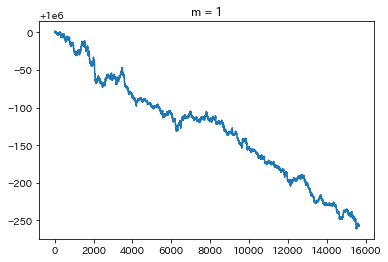

pos count: 10745, profit: -170.740


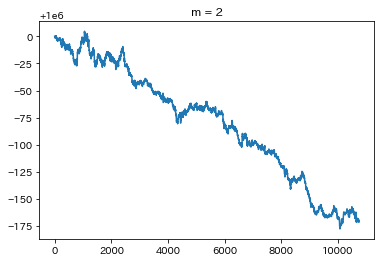

pos count:  9411, profit: -198.950


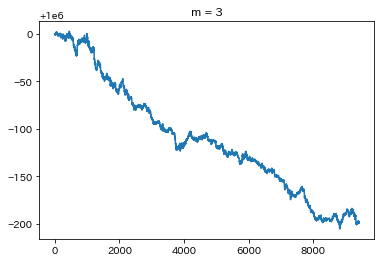

pos count:  8341, profit: -176.420


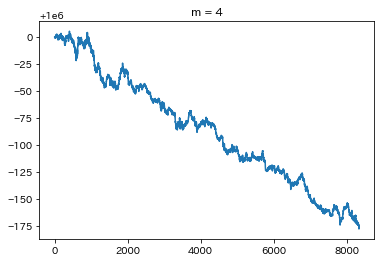

pos count:  7538, profit: -131.470


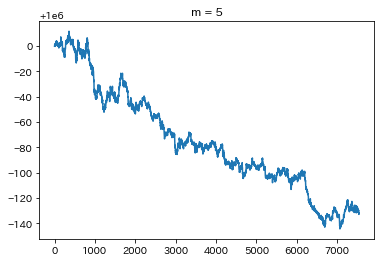

pos count:  6881, profit: -87.970


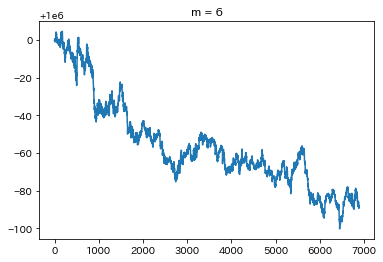

pos count:  6276, profit: -92.830


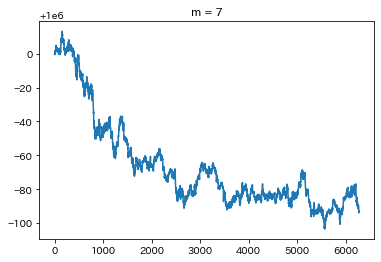

pos count:  5793, profit: -65.760


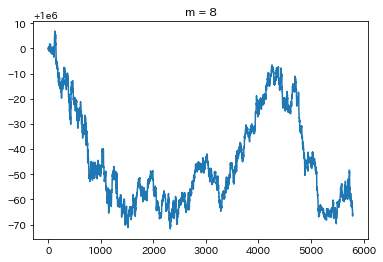

pos count:  5364, profit: -25.220


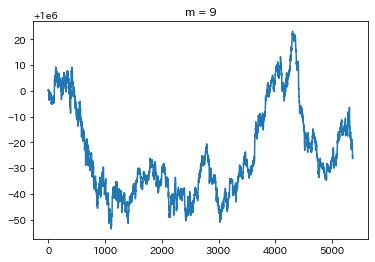

pos count:  4978, profit: -15.120


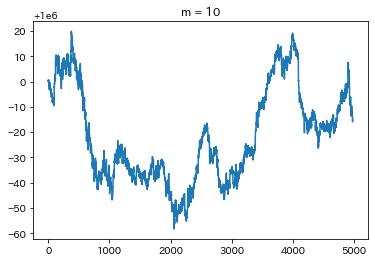

pos count:  4672, profit: -3.540


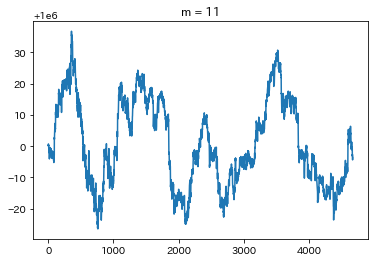

pos count:  4400, profit: -28.920


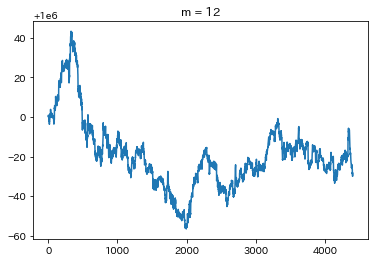

pos count:  4138, profit: 38.000


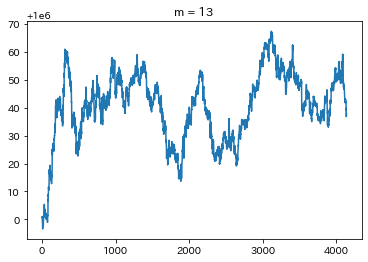

pos count:  3936, profit: 28.390


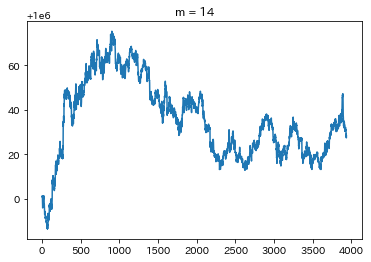

pos count:  3720, profit: 21.350


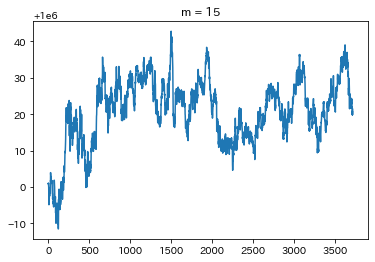

pos count:  3528, profit: 34.650


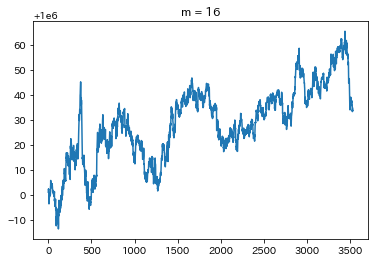

pos count:  3383, profit: 92.510


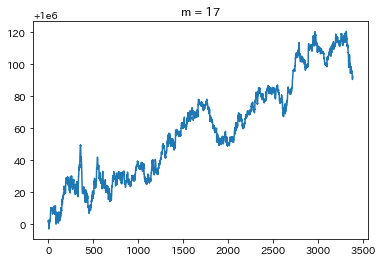

pos count:  3236, profit: 36.610


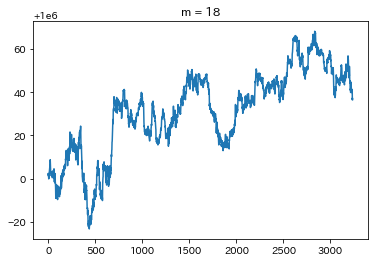

pos count:  3113, profit: 92.090


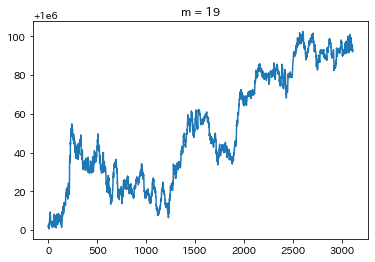

pos count:  2990, profit: 106.630


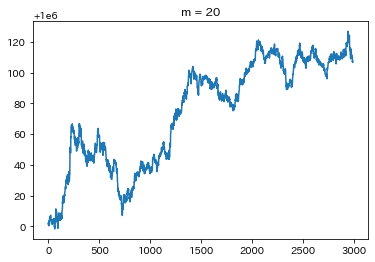

In [53]:
for i in range(20):
    pos_df, df = back_test(dfm5[dfm5['Time'].dt.year==2018], m=i+1, seed_money=1000000)
    plt.plot(pos_df['assets'])
    plt.title('m = {}'.format(i+1))
    plt.show()

pos count:  2876, profit: 67.840


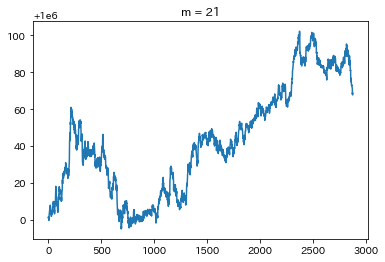

pos count:  2776, profit: 51.750


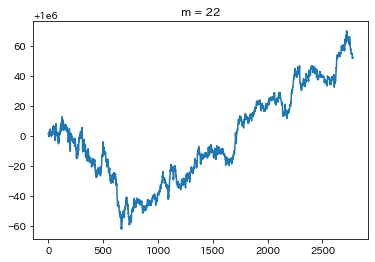

pos count:  2669, profit: 32.770


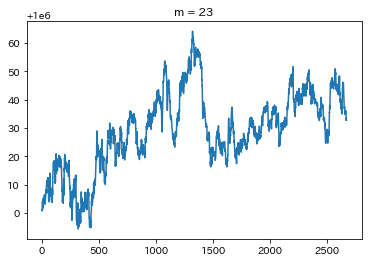

pos count:  2571, profit: 45.310


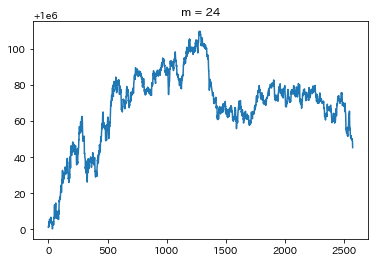

pos count:  2485, profit:  6.160


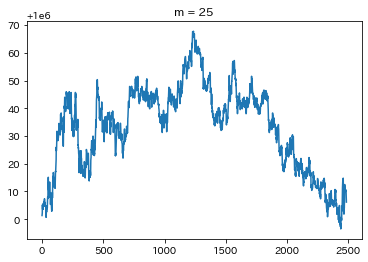

pos count:  2412, profit: 29.710


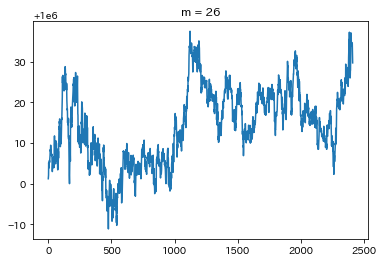

pos count:  2347, profit: 91.790


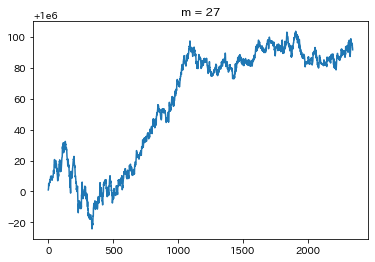

pos count:  2258, profit: 27.670


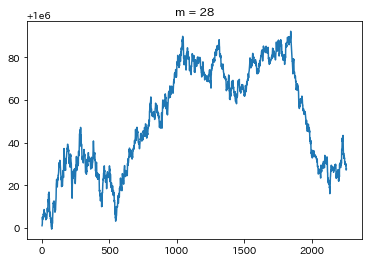

pos count:  2199, profit: 160.680


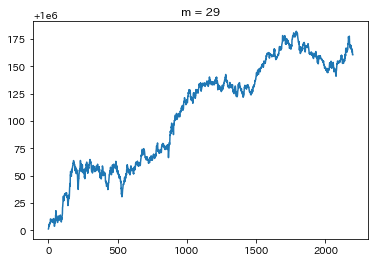

pos count:  2142, profit: 18.400


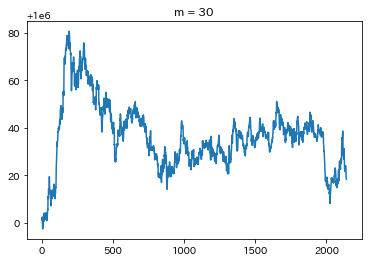

pos count:  2076, profit:  5.430


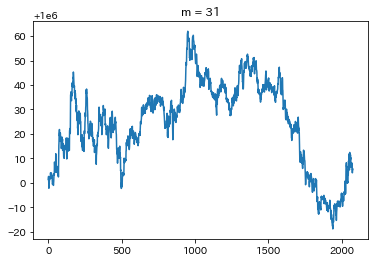

pos count:  2012, profit: -80.390


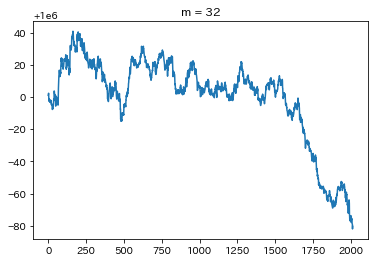

pos count:  1964, profit: -5.470


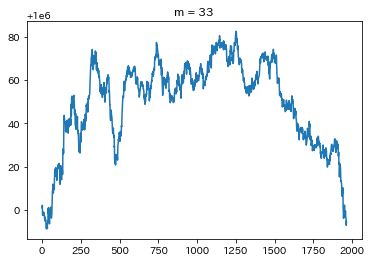

pos count:  1919, profit: 19.080


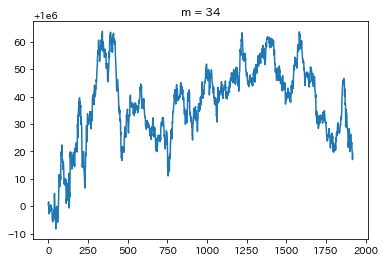

pos count:  1863, profit: -55.210


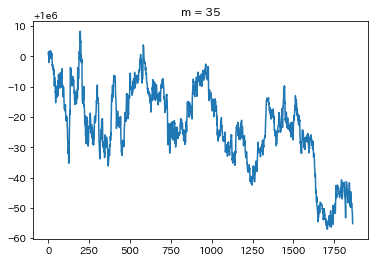

pos count:  1818, profit: 32.890


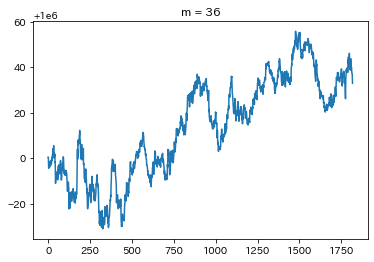

pos count:  1770, profit: -83.360


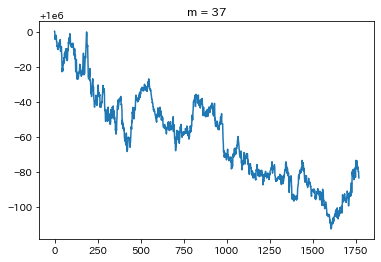

pos count:  1728, profit: -20.360


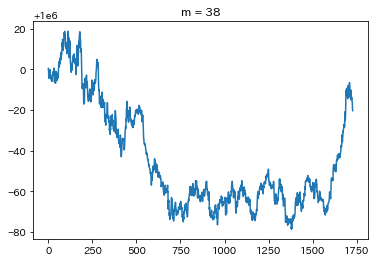

pos count:  1688, profit: -10.360


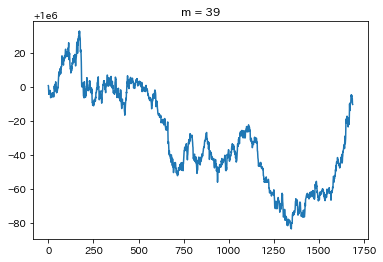

pos count:  1655, profit: -34.610


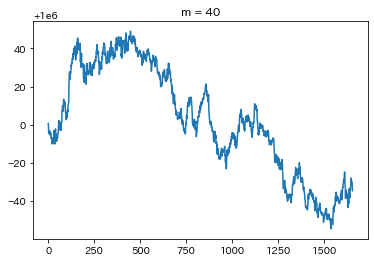

In [54]:
for i in range(20, 40):
    pos_df, df = back_test(dfm5[dfm5['Time'].dt.year==2018], m=i+1, seed_money=1000000)
    plt.plot(pos_df['assets'])
    plt.title('m = {}'.format(i+1))
    plt.show()

### 年別プロット

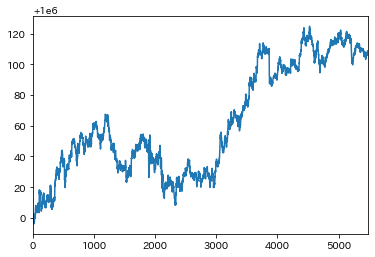

In [339]:
pos_dff[pos_dff['entry_date'].dt.year==2010]['assets'].plot()

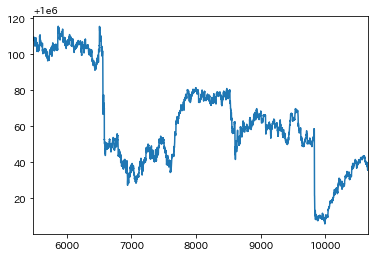

In [340]:
pos_dff[pos_dff['entry_date'].dt.year==2011]['assets'].plot()

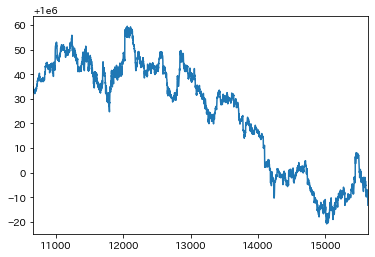

In [341]:
pos_dff[pos_dff['entry_date'].dt.year==2012]['assets'].plot()

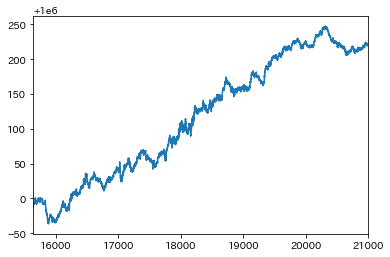

In [342]:
pos_dff[pos_dff['entry_date'].dt.year==2013]['assets'].plot()

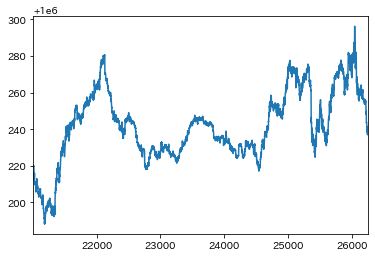

In [343]:
pos_dff[pos_dff['entry_date'].dt.year==2014]['assets'].plot()

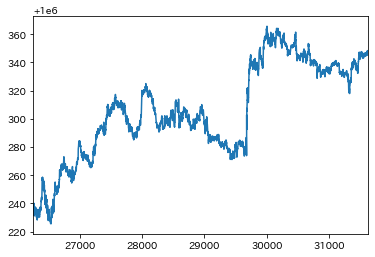

In [344]:
pos_dff[pos_dff['entry_date'].dt.year==2015]['assets'].plot()

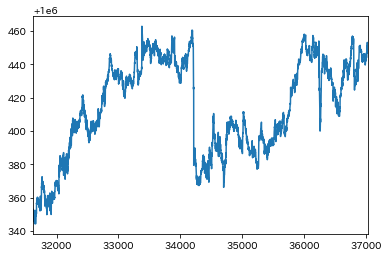

In [345]:
pos_dff[pos_dff['entry_date'].dt.year==2016]['assets'].plot()

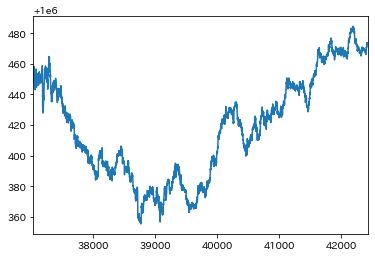

In [346]:
pos_dff[pos_dff['entry_date'].dt.year==2017]['assets'].plot()

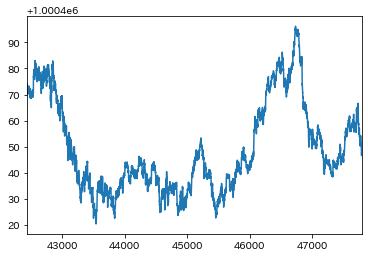

In [347]:
pos_dff[pos_dff['entry_date'].dt.year==2018]['assets'].plot()

### BT2

In [21]:
# バックテスト2
def back_test2(df, m, seed_money, start='', end='', gran='M5', lot=10, kly_rate='None'):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    tmp_i = 0
    assets = seed_money
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    pos_df = pd.DataFrame(columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])

    # 実行
    for i in range(3, len(df.index) - (1+m)):
        # up or down (Open - Close)
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud1 > ud2 > ud3 > 0:
            if pos == 'None':
                entry_rate = df.iat[i, 2] # 始値(entry)
                exit_rate = df.iat[i+m, 5] # m本後の終値
                pips = (exit_rate - entry_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'long', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                if pos_df.tail(1)['assets'].values[0] < 0:
                    break
                pos = 'entry_long'
                tmp_i = i
        # 下降トレンドと判断しショート
        if 0 > ud3 > ud2 > ud1:
            if pos == 'None':
                entry_rate = df.iat[i, 2] # 始値(entry)
                exit_rate = df.iat[i+m, 5] # m本後の終値
                pips = (entry_rate - exit_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'short', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                if pos_df.tail(1)['assets'].values[0] < 0:
                    break
                pos = 'entry_short'
                tmp_i = i
        
    print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df, df

In [22]:
# バックテスト簡易版2
def back_test_easy2(df, m, start='', end='', gran='M5'):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    profit_list = []
    pos_count = 0
    tmp_i = 0
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    # 実行
    for i in range(3, len(df.index) - (1+m)):
        entry_rate = df.iat[i, 2] # 始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値(exit)
        # up or down (Open - Close) + なら赤 - なら緑
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud1 > ud2 > ud3 > 0:
            if pos == 'None':
                profit = exit_rate - entry_rate - fee
                profit_list.append(profit)
                pos = 'entry_long'
                pos_count+=1
                tmp_i = i
        # 下降トレンドと判断しショート
        if 0 > ud3 > ud2 > ud1:
            if pos == 'None':
                profit = entry_rate - exit_rate - fee
                profit_list.append(profit)
                pos = 'entry_short'
                pos_count+=1
                tmp_i = i
        
    print('pos count: {:>5}, profit: {:>6.3f}'.format(pos_count, sum(profit_list)))

#### M5

In [31]:
for i in range(1, 50):
    print('m: {}, '.format(i), end='')
    back_test_easy2(dfm5, m=i)

m: 1, pos count: 22805, profit: 10.478
m: 2, pos count: 20484, profit:  4.572
m: 3, pos count: 20284, profit: -4.849
m: 4, pos count: 19669, profit: 16.083
m: 5, pos count: 19116, profit: 16.840
m: 6, pos count: 18643, profit:  7.804
m: 7, pos count: 18168, profit: 19.359
m: 8, pos count: 17674, profit: 23.798
m: 9, pos count: 17242, profit: 24.977
m: 10, 

KeyboardInterrupt: 

#### M1

In [24]:
for i in range(1, 50):
    print('m: {}, '.format(i), end='')
    back_test_easy2(dfm1[dfm1['Time'].dt.year==2018], m=i)

m: 1, pos count:  9666, profit: -16.814
m: 2, pos count:  8756, profit: -10.506
m: 3, pos count:  8669, profit: -13.054
m: 4, pos count:  8452, profit: -12.096
m: 5, pos count:  8227, profit: -10.228
m: 6, pos count:  8025, profit: -9.483
m: 7, pos count:  7848, profit: -7.486
m: 8, pos count:  7684, profit: -4.259
m: 9, pos count:  7536, profit: -3.538
m: 10, pos count:  7348, profit: -3.418
m: 11, pos count:  7172, profit: -2.928
m: 12, pos count:  7025, profit: -4.017
m: 13, pos count:  6899, profit: -4.570
m: 14, pos count:  6746, profit: -4.591
m: 15, pos count:  6623, profit: -3.666
m: 16, pos count:  6516, profit: -4.765
m: 17, pos count:  6394, profit: -2.788
m: 18, pos count:  6273, profit: -2.422
m: 19, pos count:  6169, profit: -1.654
m: 20, pos count:  6056, profit: -3.113
m: 21, pos count:  5946, profit: -2.851
m: 22, pos count:  5822, profit: -2.602
m: 23, pos count:  5722, profit: -4.320
m: 24, pos count:  5623, profit: -3.878
m: 25, pos count:  5536, profit: -1.928
m: 2

In [28]:
pos_df2m12017, df = back_test2(dfm1[dfm1['Time'].dt.year==2017], m=36, seed_money=1000000)

pos count:  5143, assets: 999836円


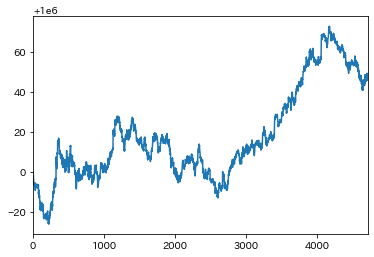

In [30]:
pos_df2m12018['assets'].plot()

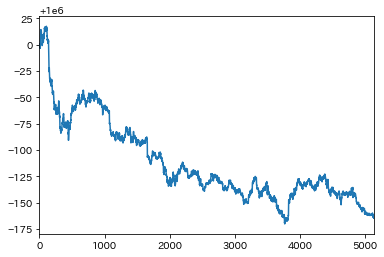

In [29]:
pos_df2m12017['assets'].plot()

#### BT2, M5, m=26

In [32]:
pos_df_M5_m26, df = back_test2(dfm5, m=26, seed_money=1000000)

pos count: 11939, assets: 1000346円


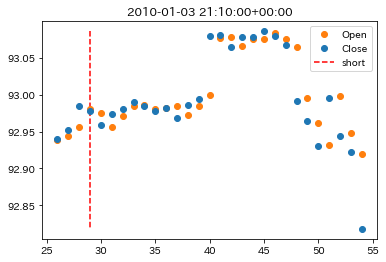

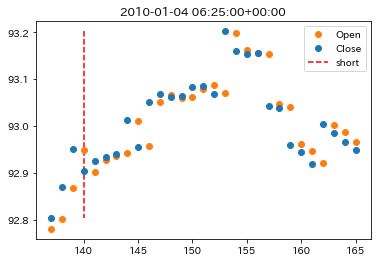

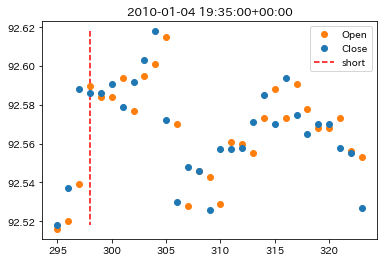

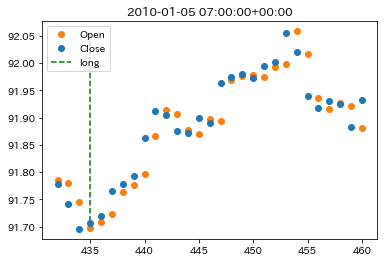

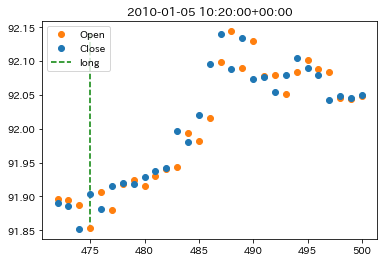

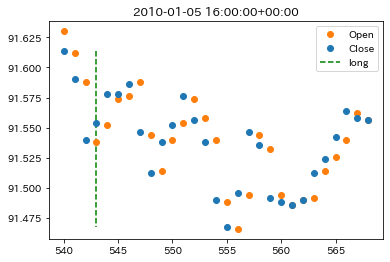

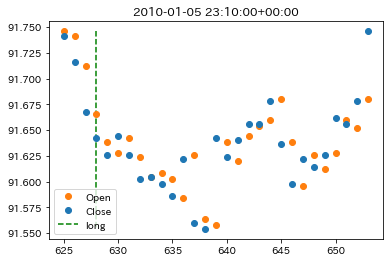

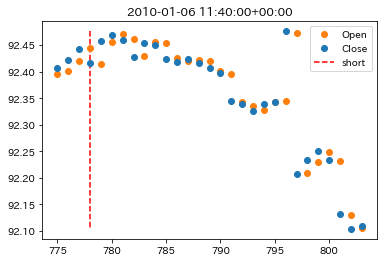

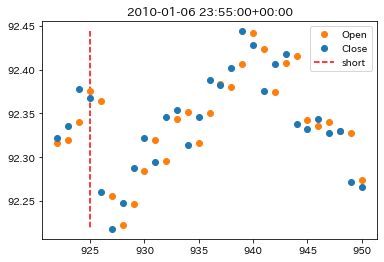

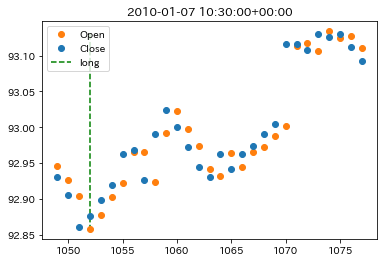

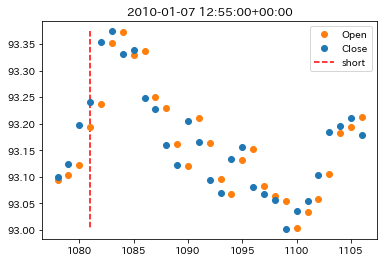

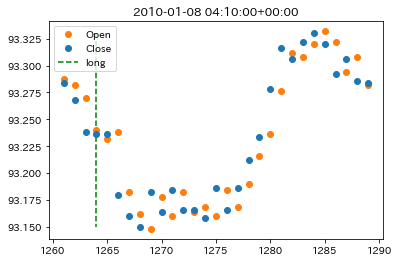

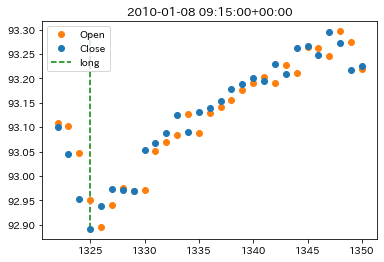

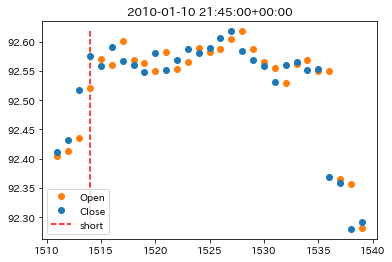

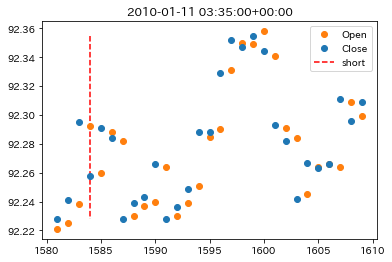

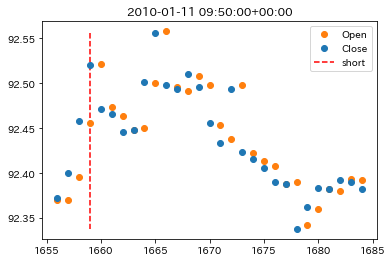

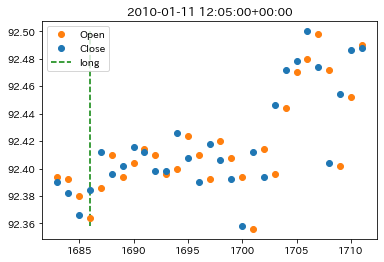

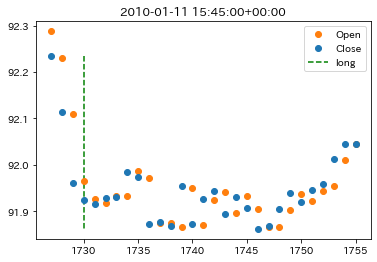

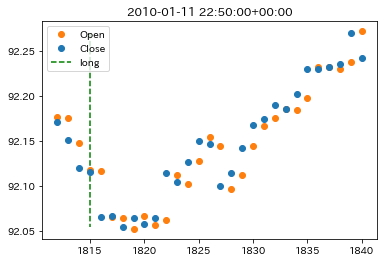

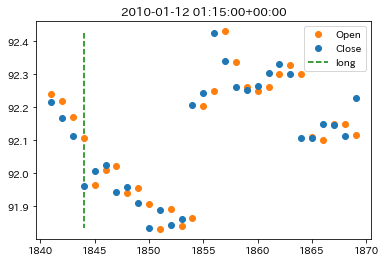

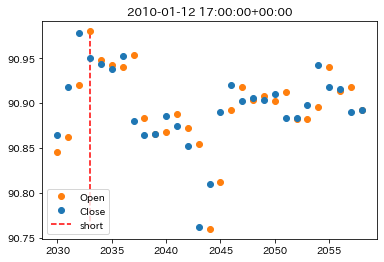

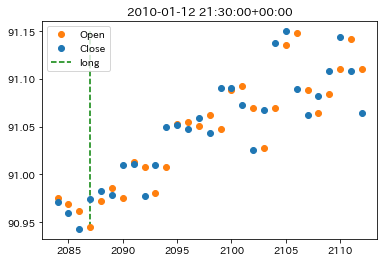

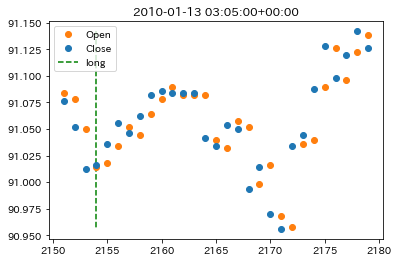

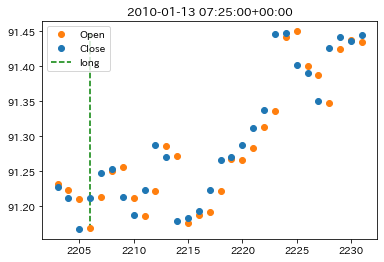

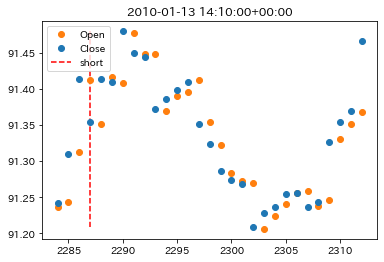

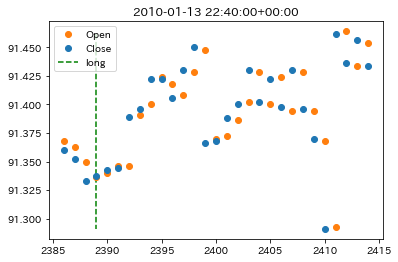

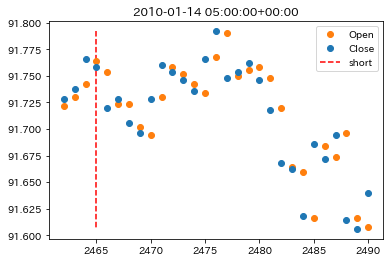

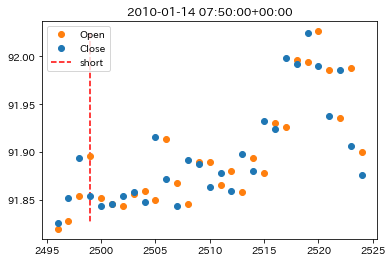

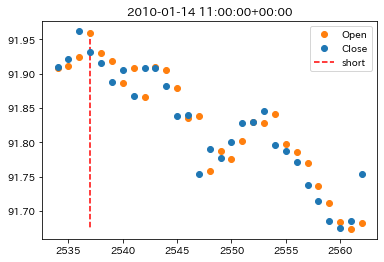

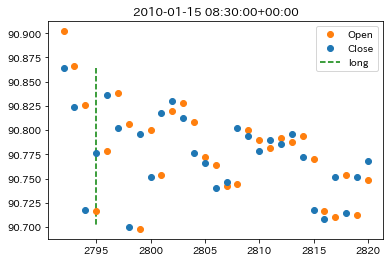

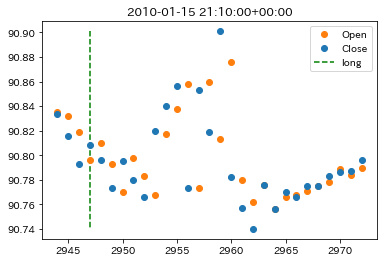

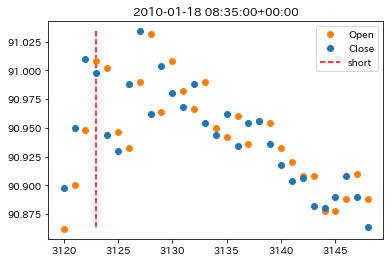

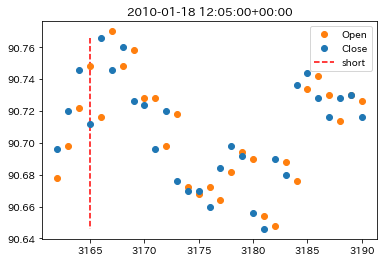

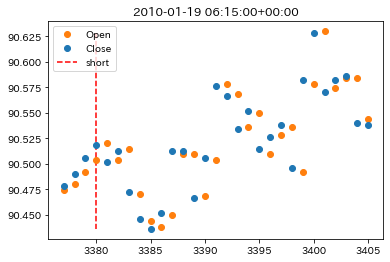

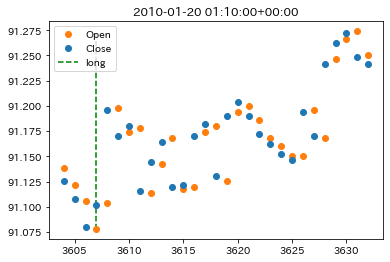

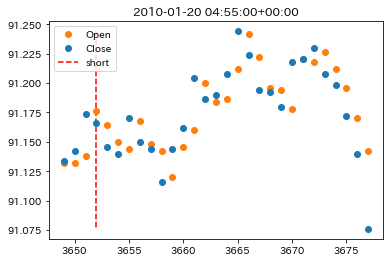

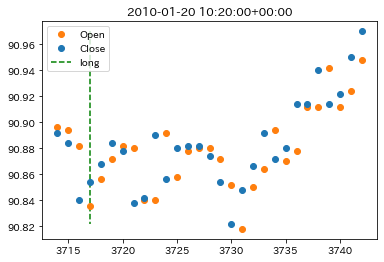

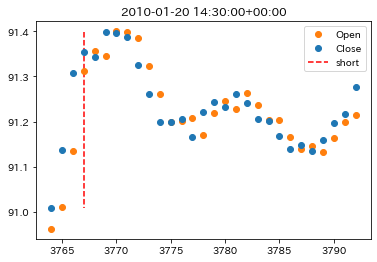

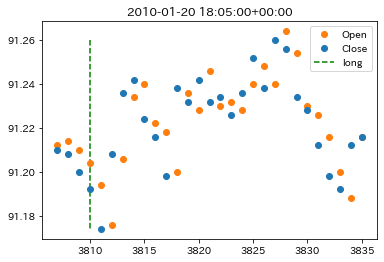

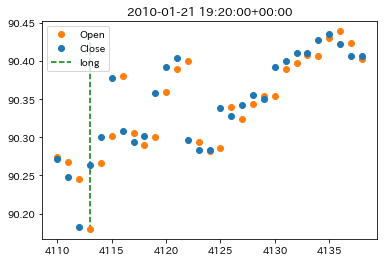

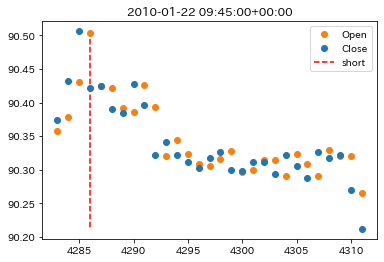

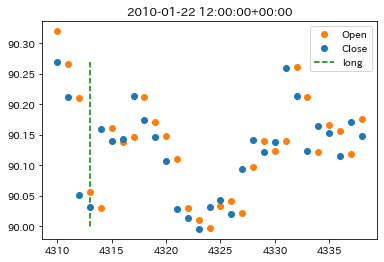

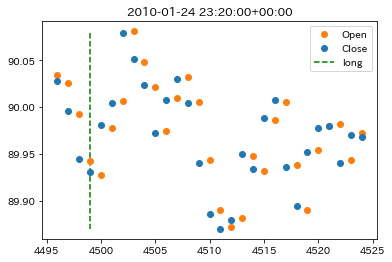

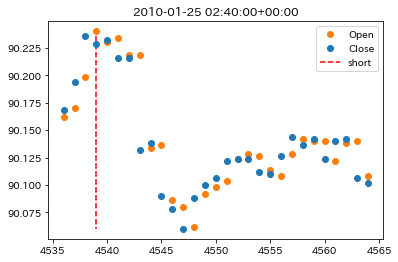

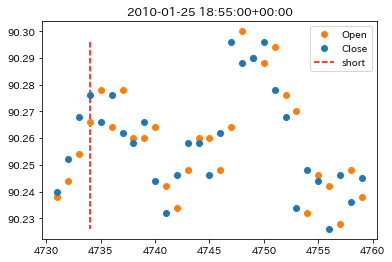

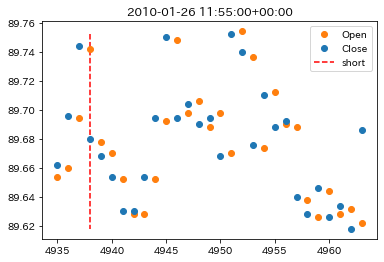

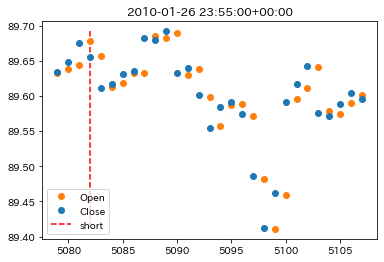

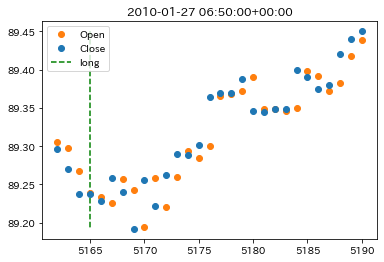

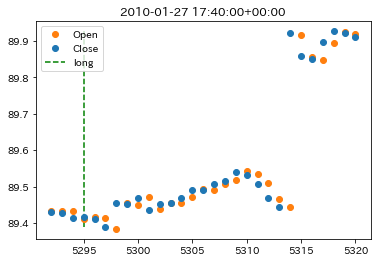

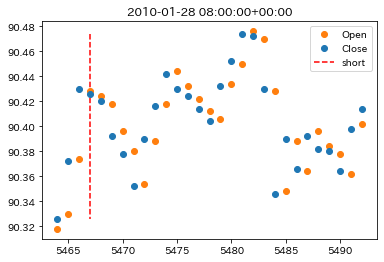

In [38]:
entry_plot(pos_df_M5_m26, dfm5, type_='win_head', m=26)

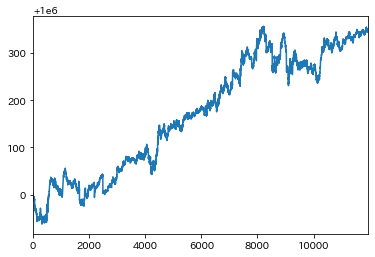

In [35]:
pos_df_M5_m26['assets'].plot()

#### BT2, M5, m=5

In [39]:
pos_df_M5_m5, df = back_test2(dfm5, m=5, seed_money=1000000)

pos count: 19116, assets: 1000168円


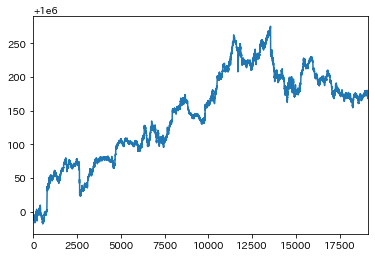

In [40]:
pos_df_M5_m5['assets'].plot()

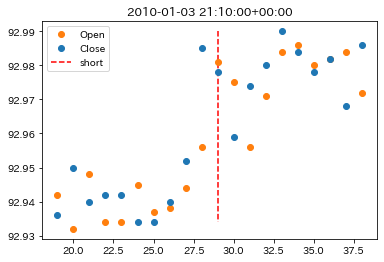

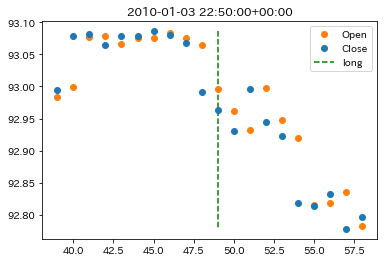

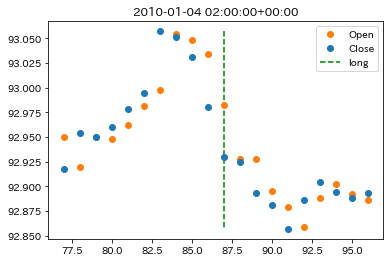

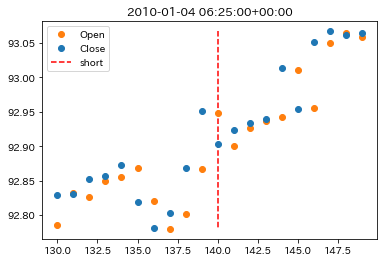

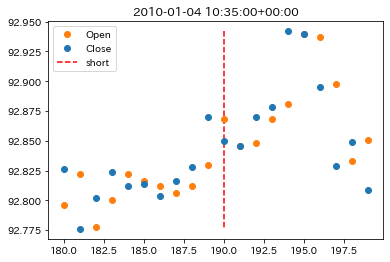

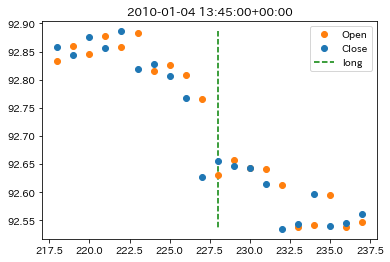

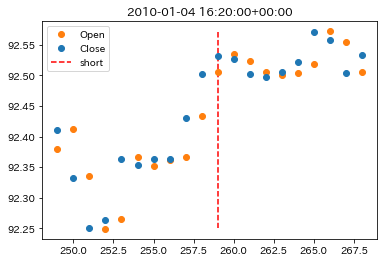

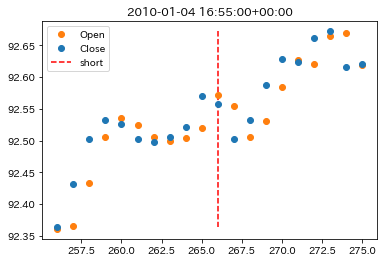

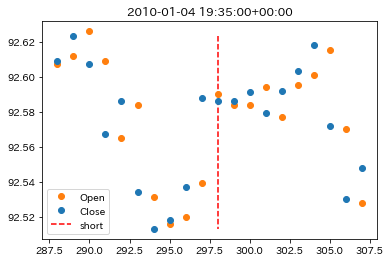

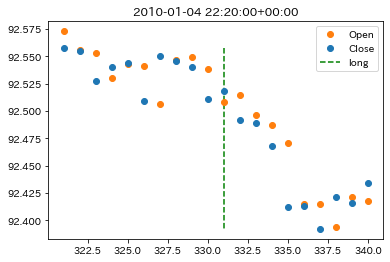

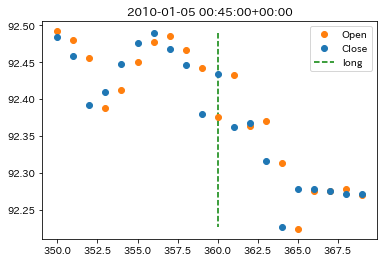

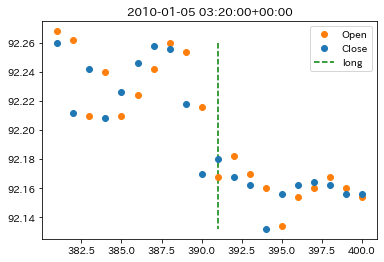

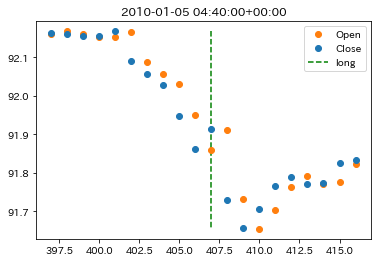

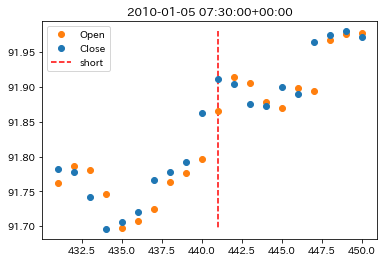

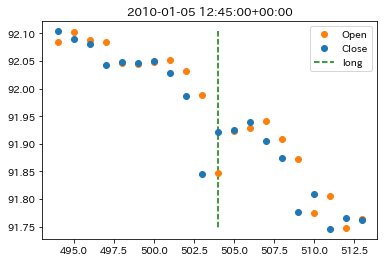

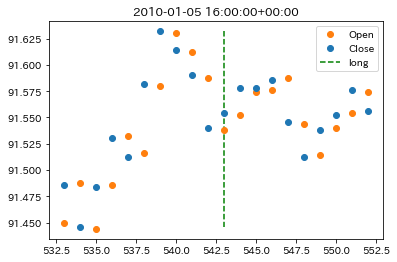

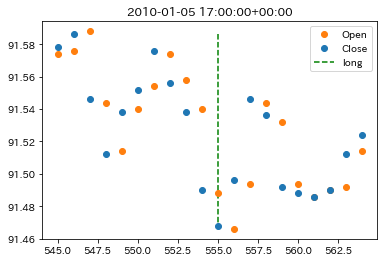

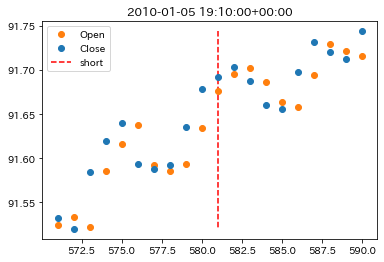

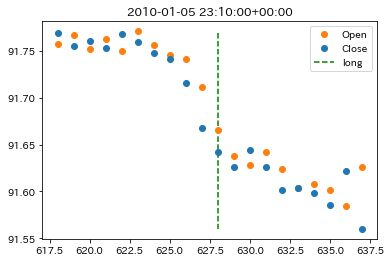

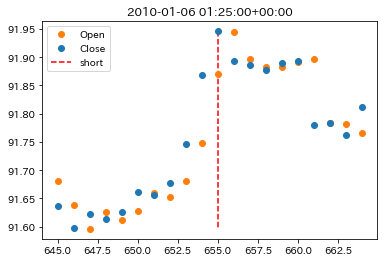

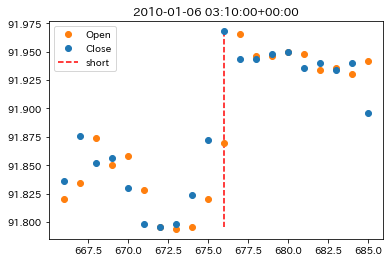

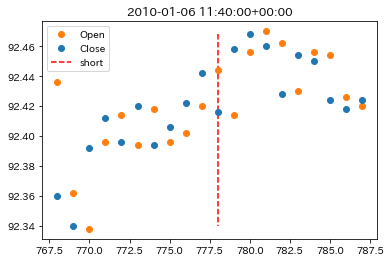

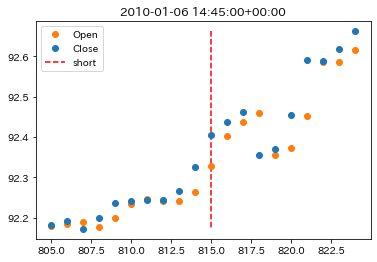

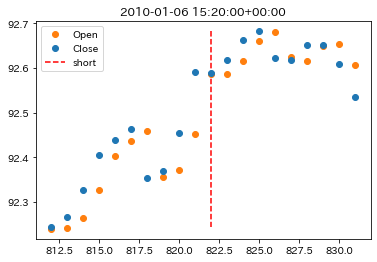

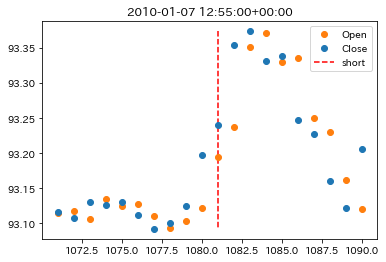

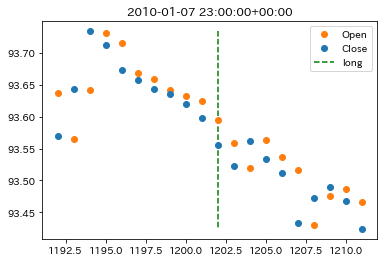

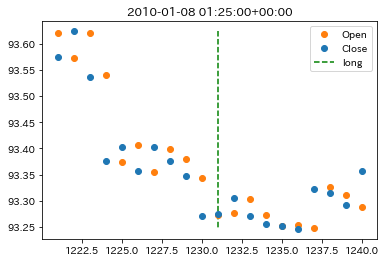

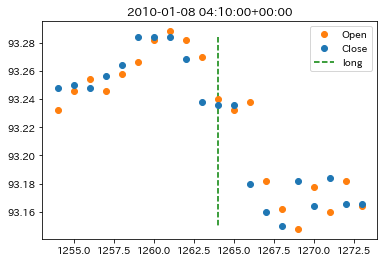

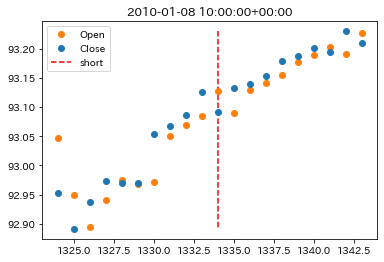

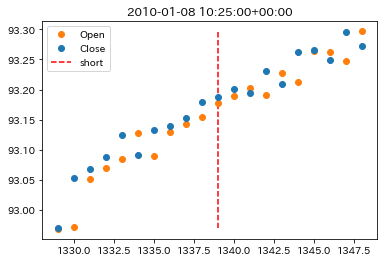

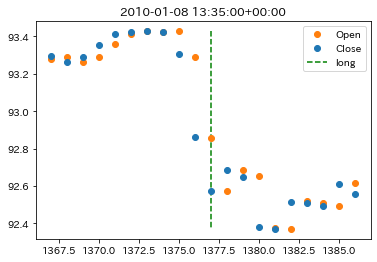

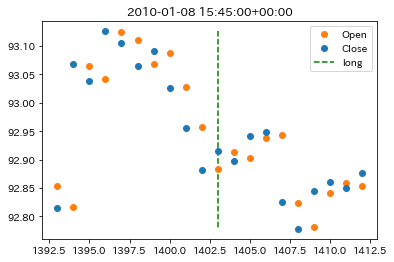

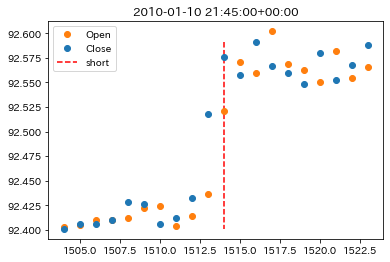

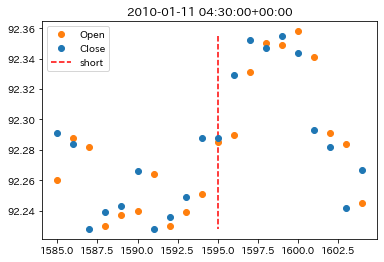

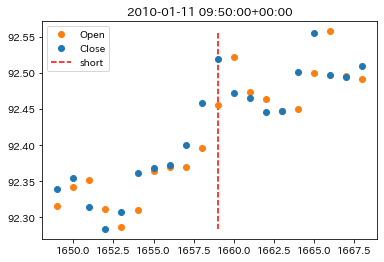

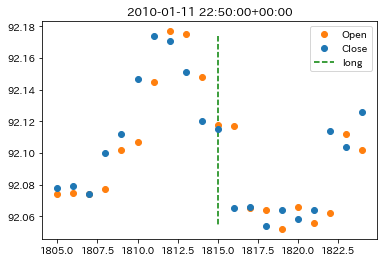

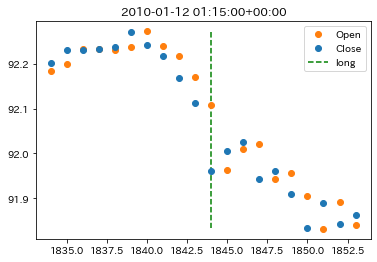

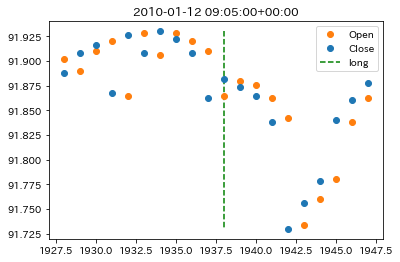

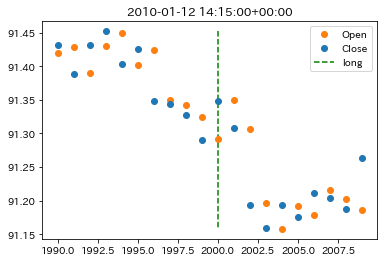

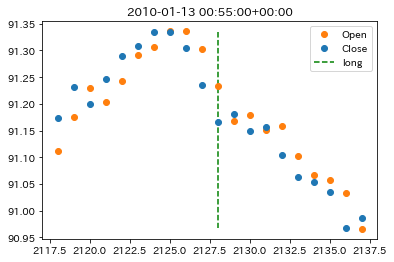

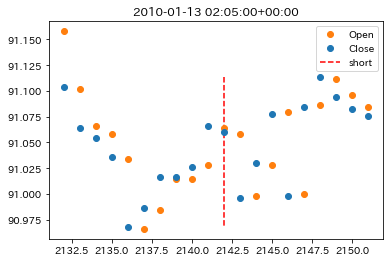

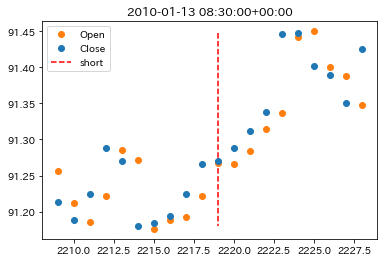

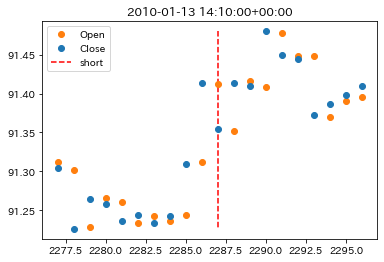

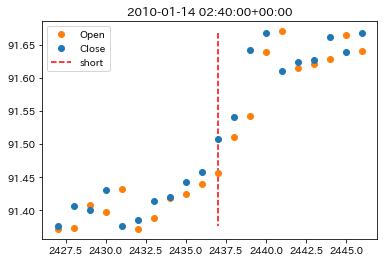

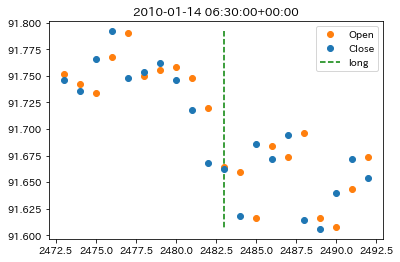

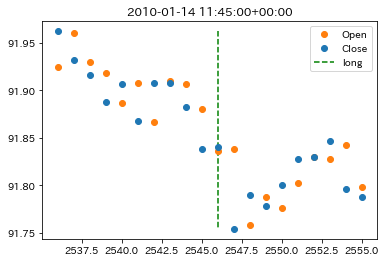

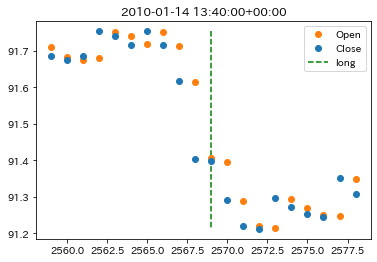

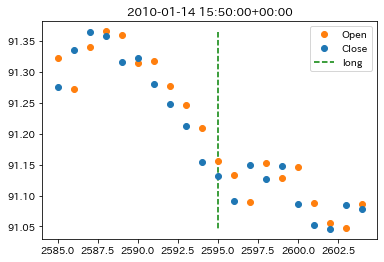

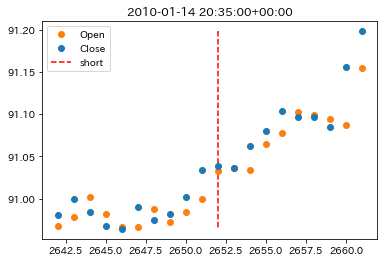

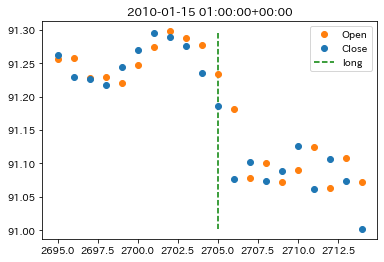

In [44]:
entry_plot(pos_df_M5_m5, dfm5, type_='lose_head', m=10, b=10)

#### m=???, plot

pos count: 22805, assets: 1000105円


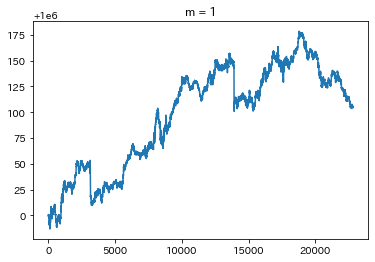

pos count: 20484, assets: 1000046円


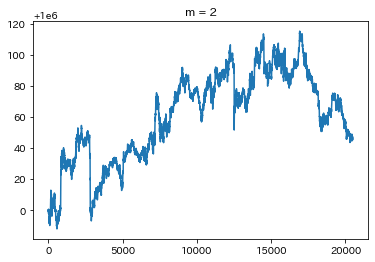

pos count: 20284, assets: 999952円


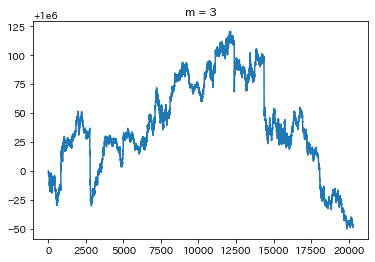

pos count: 19669, assets: 1000161円


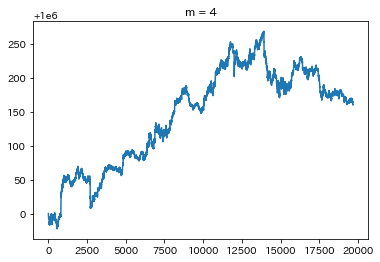

pos count: 19116, assets: 1000168円


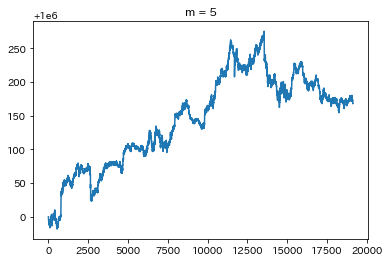

pos count: 18643, assets: 1000078円


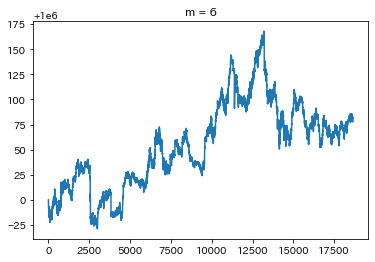

pos count: 18168, assets: 1000194円


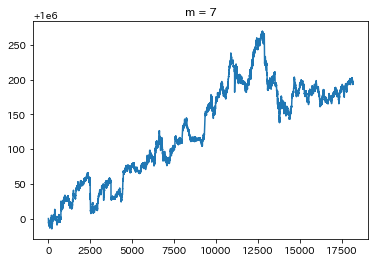

pos count: 17674, assets: 1000238円


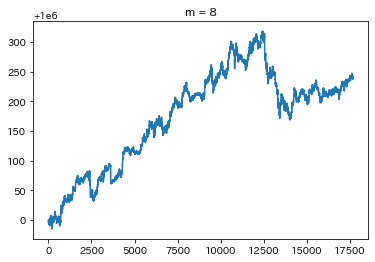

pos count: 17242, assets: 1000250円


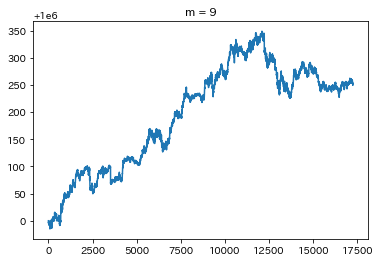

pos count: 16787, assets: 1000162円


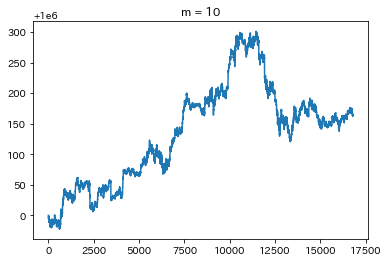

pos count: 16378, assets: 1000055円


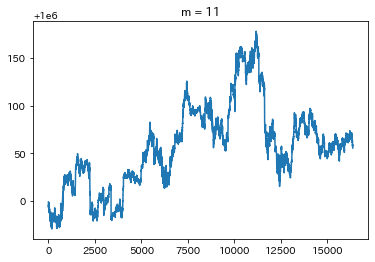

pos count: 16001, assets: 1000130円


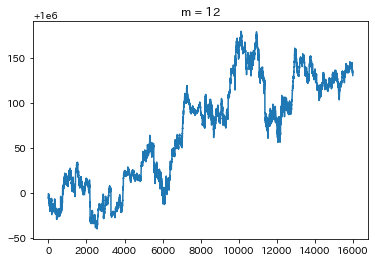

pos count: 15609, assets: 1000131円


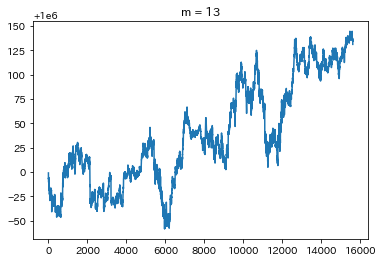

pos count: 15274, assets: 1000099円


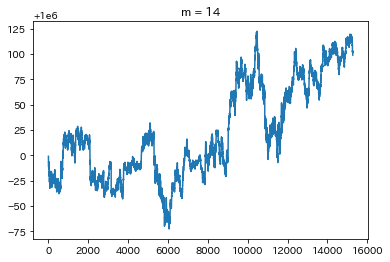

pos count: 14930, assets: 1000138円


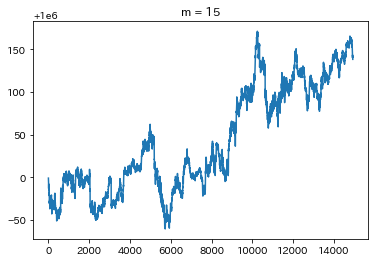

pos count: 14626, assets: 1000211円


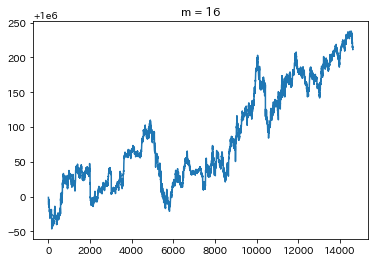

pos count: 14284, assets: 1000198円


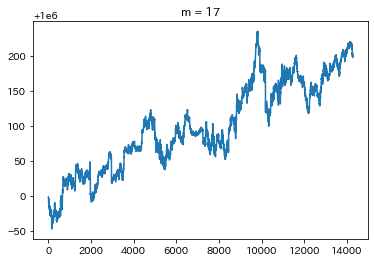

pos count: 13994, assets: 1000235円


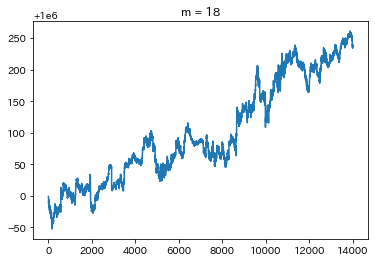

pos count: 13683, assets: 1000228円


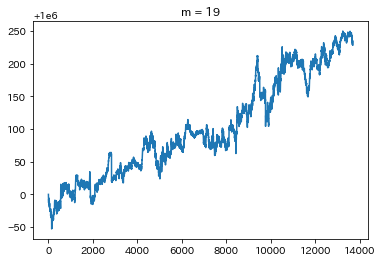

pos count: 13404, assets: 1000175円


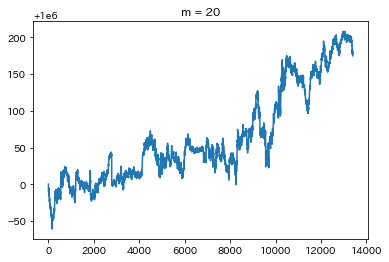

In [49]:
for i in range(20):
    pos_df, df = back_test2(dfm5, m=i+1, seed_money=1000000)
    plt.plot(pos_df['assets'])
    plt.title('m = {}'.format(i+1))
    plt.show()

pos count: 13134, assets: 1000124円


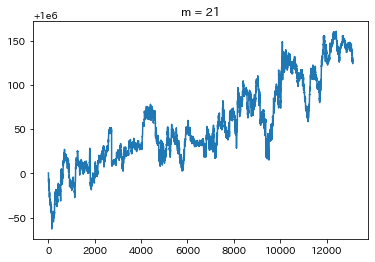

pos count: 12871, assets: 1000119円


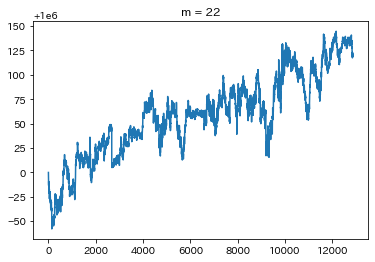

pos count: 12626, assets: 1000111円


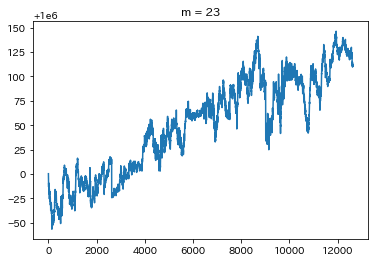

pos count: 12370, assets: 1000312円


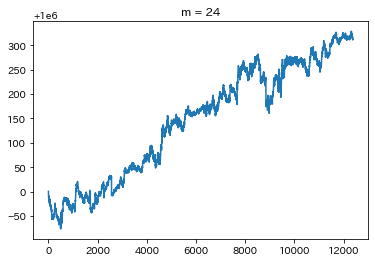

pos count: 12151, assets: 1000255円


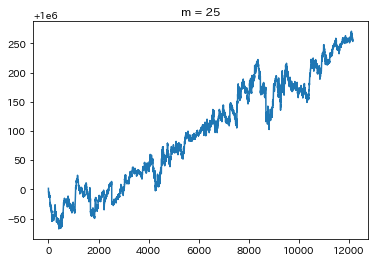

pos count: 11939, assets: 1000346円


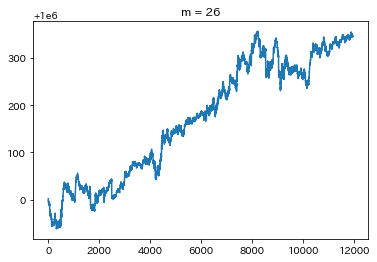

pos count: 11740, assets: 1000268円


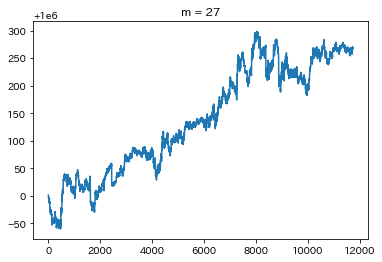

pos count: 11531, assets: 1000223円


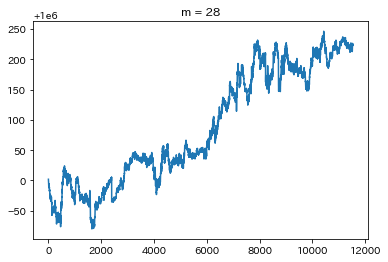

pos count: 11318, assets: 1000160円


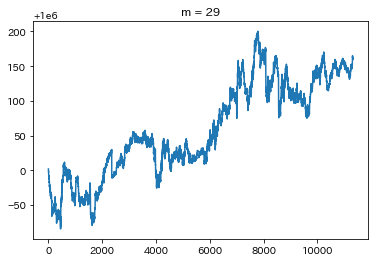

pos count: 11157, assets: 1000206円


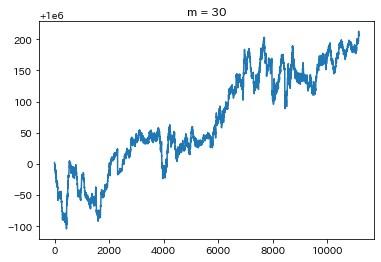

pos count: 10967, assets: 1000256円


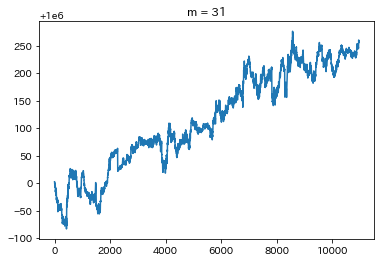

pos count: 10789, assets: 1000215円


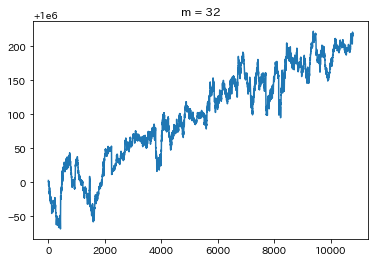

pos count: 10623, assets: 1000178円


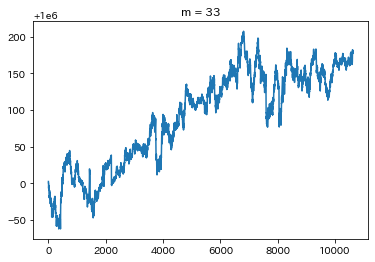

pos count: 10436, assets: 1000093円


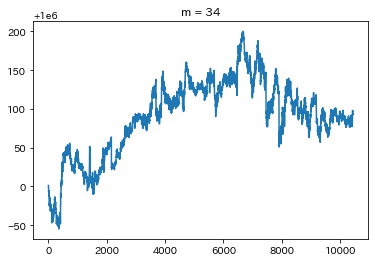

pos count: 10279, assets: 1000057円


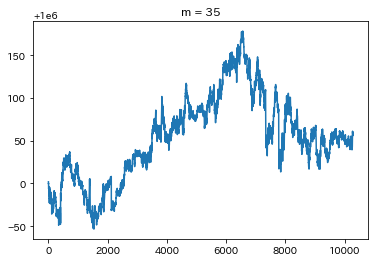

pos count: 10133, assets: 1000048円


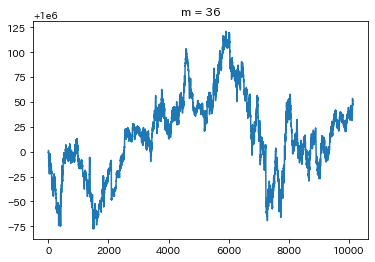

pos count:  9974, assets: 1000045円


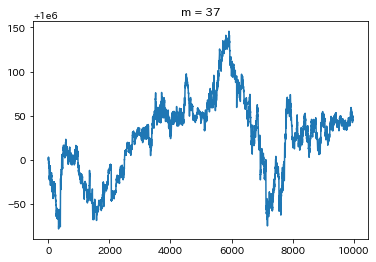

pos count:  9828, assets: 999981円


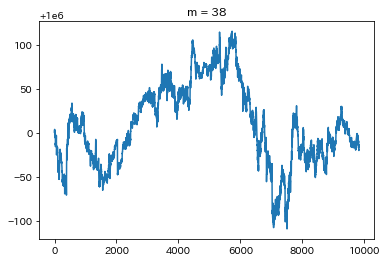

pos count:  9703, assets: 1000080円


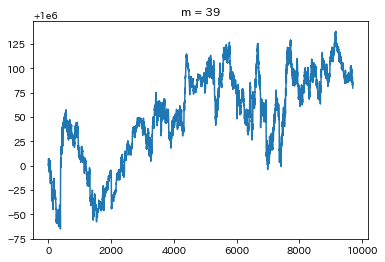

pos count:  9559, assets: 1000140円


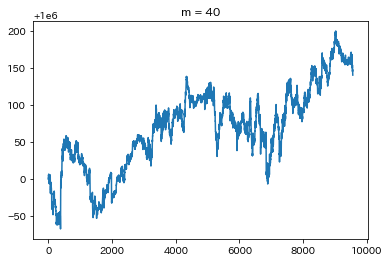

In [50]:
for i in range(20, 40):
    pos_df, df = back_test2(dfm5, m=i+1, seed_money=1000000)
    plt.plot(pos_df['assets'])
    plt.title('m = {}'.format(i+1))
    plt.show()